In [92]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.optimize
import scipy.interpolate
import sys
import functools
from gfile_helpers import read_gfile, write_gfile, plot_gfile
import time as pytime

In [160]:
try:
    raise
    import jax
    import jax.numpy as jnp
    from jax.config import config
    config.update("jax_enable_x64", True)
    x = jnp.linspace(0,5)
    y = jnp.exp(1)
    use_jax = True
    print('Using JAX',x.dtype)
except:
    jnp = np
    use_jax = False
    print('JAX borked, using numpy')
    
    
if use_jax:
    jit = jax.jit
    fori_loop = jax.lax.fori_loop
    @jit
    def put(arr,inds,vals):
        """basically a way to do arr[inds] = vals in a way that plays nice with jit/autodiff"""
        return jax.ops.index_update(arr,inds,vals)
    @jit
    def factorial(n):
        def body_fun(i,n):
            return n*i
        y = fori_loop(1.,n+1,body_fun,jnp.ones_like(n,dtype=jnp.float64))
        return y*(n>=0)

else:
    jit = lambda func, *args, **kwargs: func
    from scipy.special import factorial

    # we divide by zero in a few places but then overwrite with the 
    # correct asmptotic values, so lets suppress annoying warnings about that
    np.seterr(divide='ignore', invalid='ignore')
    arange = np.arange
    def put(arr,inds,vals):
        """basically a way to do arr[inds] = vals in a way that plays nice with jit/autodiff"""
        if isinstance(inds,tuple):
            inds = np.ravel_multi_index(inds,arr.shape)
        np.put(arr,inds,vals)
        return arr
    def fori_loop(lower, upper, body_fun, init_val):
        val = init_val
        for i in np.arange(lower, upper):
            val = body_fun(i, val)
        return val

    
    
def conditional_decorator(dec, condition, *args, **kwargs):
    """apply arbitrary decorator to a function if condition is met"""
    @functools.wraps(dec)
    def decorator(func):
        if not condition:
            # Return the function unchanged, not decorated.
            return func
        return dec(func,*args,**kwargs)
    return decorator

JAX borked, using numpy


In [131]:
colorblind_colors = [(0.0000, 0.4500, 0.7000), # blue
                     (0.8359, 0.3682, 0.0000), # vermillion
                     (0.0000, 0.6000, 0.5000), # bluish green
                     (0.9500, 0.9000, 0.2500), # yellow
                     (0.3500, 0.7000, 0.9000), # sky blue
                     (0.8000, 0.6000, 0.7000), # reddish purple
                     (0.9000, 0.6000, 0.0000)] # orange

dashes = [(1.0, 0.0, 0.0, 0.0, 0.0, 0.0), # solid
          (3.7, 1.6, 0.0, 0.0, 0.0, 0.0), # dashed
          (1.0, 1.6, 0.0, 0.0, 0.0, 0.0), # dotted
          (6.4, 1.6, 1.0, 1.6, 0.0, 0.0), # dot dash
          (3.0, 1.6, 1.0, 1.6, 1.0, 1.6), # dot dot dash
          (6.0, 4.0, 0.0, 0.0, 0.0, 0.0), # long dash
          (1.0, 1.6, 3.0, 1.6, 3.0, 1.6)] # dash dash dot
import matplotlib
from matplotlib import rcParams, cycler
matplotlib.rcdefaults()
rcParams['font.family'] = 'DejaVu Serif'
rcParams['mathtext.fontset'] = 'cm'
rcParams['font.size'] = 10
rcParams['figure.facecolor'] = (1,1,1,1)
rcParams['figure.figsize'] = (6,4)
rcParams['figure.dpi'] = 141
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['axes.labelsize'] =  'small'
rcParams['axes.titlesize'] = 'medium'
rcParams['lines.linewidth'] = 2.5
rcParams['lines.solid_capstyle'] = 'round'
rcParams['lines.dash_capstyle'] = 'round'
rcParams['lines.dash_joinstyle'] = 'round'
rcParams['xtick.labelsize'] = 'x-small'
rcParams['ytick.labelsize'] = 'x-small'
# rcParams['text.usetex']=True
color_cycle = cycler(color=colorblind_colors)
dash_cycle = cycler(dashes=dashes)
rcParams['axes.prop_cycle'] =  color_cycle

labelsize=10
ticksize=8

In [132]:
@conditional_decorator(functools.partial(jit), use_jax)
def zern_radial(x,l,m):
    """Zernike radial basis function
    
    Args:
        x (ndarray with shape(N,)): points to evaluate basis 
        l (int): radial mode number
        m (int): azimuthal mode number
    
    Returns:
        y (ndarray with shape(N,)): basis function evaluated at specified points
    """
    x = jnp.asarray(x,dtype=jnp.float64)
    y = jnp.zeros_like(x)
    lm_even = (l-m)%2 == 0
    m = jnp.abs(m)
    
    def body_fun(k,y):
        coeff = (-1)**k* factorial(l-k)/(factorial(k)* factorial((l+m)/2-k)* factorial((l-m)/2-k))
        return y + coeff*x**(l-2*k)
    kmax = ((l-m)/2.0)+1.0
    y = fori_loop(0.0,kmax,body_fun,y)

    return y*lm_even


# def zern_radial(x,l,m):
#     """Zernike radial basis function
    
#     Args:
#         x (ndarray with shape(N,)): points to evaluate basis 
#         l (int): radial mode number
#         m (int): azimuthal mode number
    
#     Returns:
#         y (ndarray with shape(N,)): basis function evaluated at specified points
#     """
#     y = jnp.zeros_like(x)
#     lm_even = (l-m)%2 == 0
#     m = jnp.abs(m)
#     k = arange(0,(l-m)/2+1,1).astype(jnp.float64)
#     coeff = (-1)**k* factorial(l-k)/(factorial(k) * factorial((l+m)//2-k) * factorial((l-m)//2-k))
#     rho = x[:,jnp.newaxis]**(l-2*k)
#     y = jnp.sum(coeff*rho,axis=1)
#     return y*lm_even

@conditional_decorator(functools.partial(jit), use_jax)
def zern_radial_r(x,l,m):
    """Zernike radial basis function, first derivative in r
    
    Args:
        x (ndarray with shape(N,)): points to evaluate basis 
        l (int): radial mode number
        m (int): azimuthal mode number
    
    Returns:
        y (ndarray with shape(N,)): basis function evaluated at specified points
    """
    x = jnp.asarray(x,dtype=jnp.float64)
    y = jnp.zeros_like(x)
    lm_even = (l-m)%2 == 0
    m = jnp.abs(m)
    def body_fun(k,y):
        coeff = (l-2*k)*(-1)**k* factorial(l-k)/(factorial(k)* factorial((l+m)/2-k)* factorial((l-m)/2-k))
        return y + coeff*x**jnp.maximum(l-2*k-1,0)
    kmax = ((l-m)/2.0)+1.0
    y = fori_loop(0.0,kmax,body_fun,y)
#     k = jnp.arange((l-m)/2+1).astype(jnp.float32)
#     coeff = (l-2*k)*(-1)**k* factorial(l-k)/(factorial(k) * factorial((l+m)//2-k) * factorial((l-m)//2-k))
#     rho = x[:,jnp.newaxis]**jnp.maximum(l-2*k-1,0)
#     y = jnp.sum(coeff*rho,axis=1)

    return y*lm_even

@conditional_decorator(functools.partial(jit), use_jax)
def zern_radial_rr(x,l,m):
    """Zernike radial basis function, second radial derivative
    
    Args:
        x (ndarray with shape(N,)): points to evaluate basis 
        l (int): radial mode number
        m (int): azimuthal mode numbe
    
    Returns:
        y (ndarray with shape(N,)): basis function evaluated at specified points
    """
    x = jnp.asarray(x,dtype=jnp.float64)
    y = jnp.zeros_like(x)
    lm_even = (l-m)%2 == 0
    m = jnp.abs(m)
    def body_fun(k,y):
        coeff = (l-2*k-1)*(l-2*k)*(-1)**k* factorial(l-k)/(factorial(k)* factorial((l+m)/2-k)* factorial((l-m)/2-k))
        return y + coeff*x**jnp.maximum(l-2*k-2,0)
    kmax = ((l-m)/2.0)+1.0
    y = fori_loop(0.0,kmax,body_fun,y)
#     k = jnp.arange((l-m)/2+1).astype(jnp.float32)
#     coeff = (l-2*k-1)*(l-2*k)*(-1)**k* factorial(l-k)/(factorial(k) * factorial((l+m)//2-k) * factorial((l-m)//2-k))
#     rho = x[:,jnp.newaxis]**jnp.maximum(l-2*k-2,0)
#     y = jnp.sum(coeff*rho,axis=1)
    
    return y*lm_even

@conditional_decorator(functools.partial(jit), use_jax)
def zern_radial_rrr(x,l,m):
    """Zernike radial basis function, third radial derivative
    
    Args:
        x (ndarray with shape(N,)): points to evaluate basis 
        l (int): radial mode number
        m (int): azimuthal mode numbe
    
    Returns:
        y (ndarray with shape(N,)): basis function evaluated at specified points
    """
    x = jnp.asarray(x,dtype=jnp.float64)
    y = jnp.zeros_like(x)
    lm_even = (l-m)%2 == 0
    m = jnp.abs(m)
    def body_fun(k,y):
        coeff = (l-2*k-2)*(l-2*k-1)*(l-2*k)*(-1)**k* factorial(l-k)/(factorial(k)* factorial((l+m)/2-k)* factorial((l-m)/2-k))
        return y + coeff*x**jnp.maximum(l-2*k-3,0)
    kmax = ((l-m)/2.0)+1.0
    y = fori_loop(0.0,kmax,body_fun,y)
#     k = jnp.arange((l-m)/2+1).astype(jnp.float32)
#     coeff = (l-2*k-1)*(l-2*k)*(-1)**k* factorial(l-k)/(factorial(k) * factorial((l+m)//2-k) * factorial((l-m)//2-k))
#     rho = x[:,jnp.newaxis]**jnp.maximum(l-2*k-2,0)
#     y = jnp.sum(coeff*rho,axis=1)
    
    return y*lm_even

@conditional_decorator(functools.partial(jit), use_jax)
def zern_azimuthal(theta,l,m):
    """Zernike azimuthal basis function
    
    Args:
        theta (ndarray with shape(N,)): points to evaluate basis
        l (int): radial mode number
        m (int): azimuthal mode number
    
    Returns:
        y (ndarray with shape(N,)): basis function evaluated at specified points
    """
    m_pos = m >= 0
    m_neg = m < 0
    m = jnp.abs(m)
    y = m_pos*jnp.cos(m*theta) + m_neg*jnp.sin(m*theta)

    return y

@conditional_decorator(functools.partial(jit), use_jax)
def zern_azimuthal_v(theta,l,m):
    """Zernike azimuthal basis function, first azimuthal derivative
    
    Args:
        theta (ndarray with shape(N,)): points to evaluate basis
        l (int): radial mode number
        m (int): azimuthal mode number
    
    Returns:
        y (ndarray with shape(N,)): basis function evaluated at specified points
    """
    m_pos = m >= 0
    m_neg = m < 0
    m = jnp.abs(m)
    y = m_pos*(-m*jnp.sin(m*theta)) + m_neg*(m*jnp.cos(m*theta))

    return y
    
@conditional_decorator(functools.partial(jit), use_jax)
def zern_azimuthal_vv(theta,l,m):
    """Zernike azimuthal basis function, second azimuthal derivative
    
    Args:
        theta (ndarray with shape(N,)): points to evaluate basis
        l (int): radial mode number
        m (int): azimuthal mode number
    
    Returns:
        y (ndarray with shape(N,)): basis function evaluated at specified points
    """
    m_pos = m >= 0
    m_neg = m < 0
    m = jnp.abs(m)
    y = m_pos*(-m**2*jnp.cos(m*theta)) + m_neg*(-m**2*jnp.sin(m*theta))

    return y

@conditional_decorator(functools.partial(jit), use_jax)
def zern_azimuthal_vvv(theta,l,m):
    """Zernike azimuthal basis function, third azimuthal derivative
    
    Args:
        theta (ndarray with shape(N,)): points to evaluate basis
        l (int): radial mode number
        m (int): azimuthal mode number
    
    Returns:
        y (ndarray with shape(N,)): basis function evaluated at specified points
    """
    m_pos = m >= 0
    m_neg = m < 0
    m = jnp.abs(m)
    y = m_pos*(m**3*jnp.sin(m*theta)) + m_neg*(-m**3*jnp.cos(m*theta))

    return y

@conditional_decorator(functools.partial(jit), use_jax)
def four_toroidal(zeta,n,NFP):
    """Toroidal Fourier basis function
    
    Args:
        zeta (ndarray with shape(N,)): coordinates to evaluate basis
        n (int): toroidal mode number
        NFP (int): number of field periods
    
    Returns:
        y (ndarray with shape(N,)): basis function evaluated at specified points
    """
    n_pos = n >= 0
    n_neg = n < 0

    n = jnp.abs(n)
    y0 = n_pos*(jnp.cos(n*NFP*zeta)) + n_neg*(jnp.sin(n*NFP*zeta))
    
    return y0

@conditional_decorator(functools.partial(jit), use_jax)
def four_toroidal_z(zeta,n,NFP):
    """Toroidal Fourier basis function, first toroidal derivative
    
    Args:
        zeta (ndarray with shape(N,)): coordinates to evaluate basis
        n (int): toroidal mode number
        NFP (int): number of field periods
    
    Returns:
        y (ndarray with shape(N,)): basis function evaluated at specified points
    """
    n_pos = n >= 0
    n_neg = n < 0
    n = jnp.abs(n)
    y1 = n_pos*(-n*NFP*jnp.sin(n*NFP*zeta)) + n_neg*(n*NFP*jnp.cos(n*NFP*zeta))
    
    return y1

@conditional_decorator(functools.partial(jit), use_jax)
def four_toroidal_zz(zeta,n,NFP):
    """Toroidal Fourier basis function, second toroidal derivative
    
    Args:
        zeta (ndarray with shape(N,)): coordinates to evaluate basis
        n (int): toroidal mode number
        NFP (int): number of field periods
    
    Returns:
        y (ndarray with shape(N,)): basis function evaluated at specified points
    """
    n_pos = n >= 0
    n_neg = n < 0
    n = jnp.abs(n)
    y2 = n_pos*(-(n*NFP)**2*jnp.cos(n*NFP*zeta)) + n_neg*(-(n*NFP)**2*jnp.sin(n*NFP*zeta))
    
    return y2

@conditional_decorator(functools.partial(jit), use_jax)
def four_toroidal_zzz(zeta,n,NFP):
    """Toroidal Fourier basis function, third toroidal derivative
    
    Args:
        zeta (ndarray with shape(N,)): coordinates to evaluate basis
        n (int): toroidal mode number
        NFP (int): number of field periods
    
    Returns:
        y (ndarray with shape(N,)): basis function evaluated at specified points
    """
    n_pos = n >= 0
    n_neg = n < 0
    n = jnp.abs(n)
    y2 = n_pos*((n*NFP)**3*jnp.sin(n*NFP*zeta)) + n_neg*(-(n*NFP)**3*jnp.cos(n*NFP*zeta))
    
    return y2

radial_derivatives = {0: zern_radial,
                      1: zern_radial_r,
                      2: zern_radial_rr,
                      3: zern_radial_rrr}
poloidal_derivatives = {0: zern_azimuthal,
                        1: zern_azimuthal_v,
                        2: zern_azimuthal_vv,
                        3: zern_azimuthal_vvv}
toroidal_derivatives = {0: four_toroidal,
                        1: four_toroidal_z,
                        2: four_toroidal_zz,
                        3: four_toroidal_zzz}

@conditional_decorator(functools.partial(jit,static_argnums=(4,5)), use_jax)
def zern(r,theta,l,m,dr,dtheta):
    """Zernike 2D basis function
    
    Args:
        r (ndarray with shape(N,)): radial coordinates to evaluate basis
        theta (array-like): azimuthal coordinates to evaluate basis
        l (int): radial mode number
        m (int): azimuthal mode number
        dr (int): order of radial derivative
        dtheta (int): order of azimuthal derivative
    
    Returns:
        y (ndarray with shape(N,)): basis function evaluated at specified points
    """
    radial = radial_derivatives[dr](r,l,m)
    azimuthal = poloidal_derivatives[dtheta](theta,l,m)
    
    return radial*azimuthal    

@conditional_decorator(functools.partial(jit,static_argnums=(3,)), use_jax)
def four(zeta,n,NFP,dz):
    """Toroidal Fourier basis function
    
    Args:
        zeta (ndarray with shape(N,)): coordinates to evaluate basis
        n (int): toroidal mode number
        NFP (int): number of field periods
        dz (int): order of toroidal derivative
    
    Returns:
        y (ndarray with shape(N,)): basis function evaluated at specified points
    """
    return toroidal_derivatives[dz](zeta,n,NFP)
    
@conditional_decorator(functools.partial(jit), use_jax)
def double_fourier_basis(theta,phi,m,n,NFP):
    """Double Fourier series for boundary/lambda
    
    Args:
        theta (ndarray with shape(N,)): poloidal angle to evaluate basis
        phi (ndarray with shape(N,)): toroidal angle to evaluate basis
        m (int): poloidal mode number
        n (int): toroidal mode number
        NFP (int): number of field periods
    
    Returns:
        y (ndarray with shape(N,)): basis function evaluated at specified points
    """
    m_pos = m >= 0
    m_neg = m < 0
    n_pos = n >= 0
    n_neg = n < 0
    m = jnp.abs(m)
    n = jnp.abs(n)
    m_term = m_pos*jnp.cos(m*theta) + m_neg*jnp.sin(m*theta)
    n_term = n_pos*jnp.cos(n*NFP*phi) + n_neg*jnp.sin(n*NFP*phi)

    return m_term*n_term

@conditional_decorator(functools.partial(jit,static_argnums=(7,8,9)), use_jax)
def fourzern(r,theta,zeta,l,m,n,NFP,dr,dv,dz):
    """Combined 3D Fourier-Zernike basis function
    
    Args:
        r (ndarray with shape(N,)): radial coordinates
        theta (ndarray with shape(N,)): poloidal coordinates
        zeta (ndarray with shape(N,)): toroidal coordinates
        l (int): radial mode number
        m (int): poloidal mode number
        n (int): toroidal mode number
        NFP (int): number of field periods
        dr (int): order of radial derivative
        dv (int): order of poloidal derivative
        dz (int): order of toroidal derivative
    
    Returns:
        y (ndarray with shape(N,)): basis function evaluated at specified points
    """
    return zern(r,theta,l,m,dr,dv)*four(zeta,n,NFP,dz)


In [133]:
class ZernikeTransform():
    """Zernike Transform (really a Fourier-Zernike, but whatever)
    
    Args:
        nodes (ndarray, shape(3,N)): nodes where basis functions are evaluated. 
            First index is (rho,theta,phi), 2nd index is node number
        mode_idx (ndarray of int, shape(Nc,3)): mode numbers for spectral basis. each row is one basis function with 
            modes (l,m,n)
        NFP (int): number of field periods   
        derivatives (array-like, shape(n,3)): orders of derivatives to compute in rho,theta,zeta.
            Each row of the array should contain 3 elements corresponding to derivatives in rho,theta,zeta
    """
    def __init__(self,nodes, mode_idx,NFP,derivatives=[0,0,0]):
        # array of which l,m,n is at which column of the interpolation matrix
        self.mode_idx = mode_idx
        # array of which r,v,z is at which row of the interpolation matrix
        self.nodes = nodes
        self.NFP = NFP
        self.derivatives = np.atleast_2d(derivatives)
        self.matrices = {i:{j:{k:{} for k in range(4)} for j in range(4)} for i in range(4)}
        self._build(self.derivatives,self.mode_idx)
    
    def _build(self,derivs, mode_idx):
        for d in derivs:
            dr = d[0]
            dv = d[1]
            dz = d[2]
            self.matrices[dr][dv][dz] = jnp.stack([fourzern(self.nodes[0],self.nodes[1],self.nodes[2],
                                               lmn[0],lmn[1],lmn[2],self.NFP,dr,dv,dz) for lmn in mode_idx]).T 
            
    def expand_nodes(self,new_nodes):
        """Change the real space resolution by adding new nodes without full recompute
        
        Only computes basis at spatial nodes that aren't already in the basis
        
        Args:
            new_nodes (ndarray, side(N,3)): new node locations. each row is the location of one node (rho,theta,zeta)
        """
        
        new_nodes = jnp.atleast_2d(new_nodes)
        # first remove nodes that are no longer needed
        old_in_new = (self.nodes[:, None] == new_nodes).all(-1).any(-1)
        for d in self.derivatives:
            self.matrices[d[0]][d[1]][d[2]] = self.matrices[d[0]][d[1]][d[2]][old_in_new]
        self.nodes = self.nodes[old_in_new]
        
        # then add new nodes
        new_not_in_old = ~(new_nodes[:, None] == self.nodes).all(-1).any(-1)
        nodes_to_add = new_nodes[new_not_in_old]
        for d in self.derivatives:
            self.matrices[d[0]][d[1]][d[2]] = jnp.vstack([
                self.matrices[d[0]][d[1]][d[2]], # old
                jnp.stack([fourzern(nodes_to_add[:,0],nodes_to_add[:,1],nodes_to_add[:,2], # new
                lmn[0],lmn[1],lmn[2],self.NFP,d[0],d[1],d[2]) for lmn in self.mode_idx]).T ])
        
        # update indices
        self.nodes = np.vstack([self.nodes, nodes_to_add])
        # permute indexes so they're in the same order as the input
        permute_idx = [new_nodes.tolist().index(i) for i in self.nodes.tolist()]
        for d in self.derivatives:
            self.matrices[d[0]][d[1]][d[2]] = self.matrices[d[0]][d[1]][d[2]][permute_idx]
        self.nodes = self.nodes[permute_idx]
        
    
    def expand_spectral_resolution(self,mode_idx_new):
        """Change the spectral resolution of the transform without full recompute
        
        Only computes modes that aren't already in the basis
        
        Args:
            mode_idx_new (ndarray of int, shape(Nc,3)): new mode numbers for spectral basis. 
                each row is one basis function with modes (l,m,n)        
        """
        
        mode_idx_new = jnp.atleast_2d(mode_idx_new)
        # first remove modes that are no longer needed
        old_in_new = (self.mode_idx[:, None] == mode_idx_new).all(-1).any(-1)
        for d in self.derivatives:
            self.matrices[d[0]][d[1]][d[2]] = self.matrices[d[0]][d[1]][d[2]][:,old_in_new]
        self.mode_idx = self.mode_idx[old_in_new]
        
        # then add new modes
        new_not_in_old = ~(mode_idx_new[:, None] == self.mode_idx).all(-1).any(-1)
        modes_to_add = mode_idx_new[new_not_in_old]
        for d in self.derivatives:
            self.matrices[d[0]][d[1]][d[2]] = jnp.hstack([
                self.matrices[d[0]][d[1]][d[2]], # old
                jnp.stack([fourzern(self.nodes[0],self.nodes[1],self.nodes[2], # new
                lmn[0],lmn[1],lmn[2],self.NFP,d[0],d[1],d[2]) for lmn in modes_to_add]).T ])
        
        # update indices
        self.mode_idx = np.vstack([self.mode_idx, modes_to_add])
        # permute indexes so they're in the same order as the input
        permute_idx = [mode_idx_new.tolist().index(i) for i in self.mode_idx.tolist()]
        for d in self.derivatives:
            self.matrices[d[0]][d[1]][d[2]] = self.matrices[d[0]][d[1]][d[2]][:,permute_idx]
        self.mode_idx = self.mode_idx[permute_idx]
                
    def expand_derivatives(self,new_derivatives):
        """Computes new derivative matrices
        
        Args:
            new_derivatives (array-like, shape(n,3)): orders of derivatives 
                to compute in rho,theta,zeta. Each row of the array should 
                contain 3 elements corresponding to derivatives in rho,theta,zeta
        """

        new_not_in_old = (new_derivatives[:, None] == self.derivatives).all(-1).any(-1)
        derivs_to_add = new_derivatives[~new_not_in_old]
        self._build(derivs_to_add, self.mode_idx)
        self.derivatives = jnp.vstack([self.derivatives,derivs_to_add])
        
        
    @conditional_decorator(functools.partial(jit,static_argnums=(0,2,3,4)), use_jax)    
    def transform(self,c,dr,dv,dz):
        """Transform from spectral domain to physical
        
        Args:
            c (ndarray, shape(N_coeffs,)): spectral coefficients, indexed as (lm,n) flattened in row major order
            dr (int): order of radial derivative
            dv (int): order of poloidal derivative
            dz (int): order of toroidal derivative
            
        Returns:
            x (ndarray, shape(N_nodes,)): array of values of function at node locations
        """
        return jnp.matmul(self.matrices[dr][dv][dz],c)

    @conditional_decorator(functools.partial(jit,static_argnums=(0,2)), use_jax)    
    def fit(self,x,rcond=1e-6):
        """Transform from physical domain to spectral
        
        Args:
            x (ndarray, shape(N_nodes,)): values in real space at coordinates specified by self.nodes
            rcond (float): relative cutoff for singular values in least squares fit  
            
        Returns:
            c (ndarray, shape(N_coeffs,)): spectral coefficients in Fourier-Zernike basis
        """
        return jnp.linalg.lstsq(self.matrices[0][0][0],x,rcond=rcond)[0]
        

In [134]:
def get_zern_basis_idx_dense(M,N):
    num_lm_modes = (M+1)**2
    num_four = 2*N+1
    return jnp.array([(*fringe_to_lm(i),n-N) for i in range(num_lm_modes) for n in range(num_four)])

def get_double_four_basis_idx_dense(M,N):
    dimFourM = 2*M+1
    dimFourN = 2*N+1
    return jnp.array([[m-M,n-N] for m in range(dimFourM) for n in range(dimFourN)])

def zernike_norm(l, m):
    """Norm of a Zernike polynomial with l, m indexing.
    Borrowed from prysm: https://github.com/brandondube/prysm
    """
    return jnp.sqrt((2 * (l + 1)) / (1 + jnp.kronecker(m, 0)))

def lm_to_fringe(l, m):
    """Convert (l,m) two term index to Fringe index.
    Borrowed from prysm: https://github.com/brandondube/prysm
    """
    term1 = (1 + (l + jnp.abs(m))/2)**2
    term2 = 2 * jnp.abs(m)
    term3 = (1 + jnp.sign(m)) / 2
    return int(term1 - term2 - term3)  

def fringe_to_lm(idx):
    """Convert Fringe Z to (l, m) two-term index.
    Borrowed from prysm: https://github.com/brandondube/prysm
    """
    idx += 1 # shift 0 base to 1 base
    m_l = 2 * (jnp.ceil(jnp.sqrt(idx)) - 1)  # sum of n+m
    g_s = (m_l / 2)**2 + 1  # start of each group of equal n+m given as idx index
    l = m_l / 2 + jnp.floor((idx - g_s) / 2)
    m = (m_l - l) * (1 - jnp.mod(idx-g_s, 2) * 2)
    return int(l), int(m)

def lm_to_ansi_j(l, m):
    """Convert (n,m) two term index to ANSI single term index.
    Borrowed from prysm: https://github.com/brandondube/prysm
    """
    return int((l * (l + 2) + m) / 2)


def ansi_j_to_lm(idx):
    """Convert ANSI single term to (n,m) two-term index.
    Borrowed from prysm: https://github.com/brandondube/prysm
    """
    l = int(jnp.ceil((-3 + jnp.sqrt(9 + 8*idx))/2))
    m = 2 * idx - l * (l + 2)
    return l, m


class JacobiCoeffs():
    def __init__(self,M):
        self.coeffs = {}
        for i in range((M+1)**2):
            l,m = fringe_to_lm(i)
            self._compute_coeffs(l,m)
    def _compute_coeffs(self,l,m):
        lm_even = (l-m)%2 == 0
        m = abs(m)
        self.coeffs[(l,m)] = np.array([lm_even*(-1)**k* factorial(l-k)/(
            factorial(k) * factorial((l+m)//2-k) * factorial((l-m)//2-k)) for k in np.arange(0,(l-m)/2+1,1).astype(np.float64)]) 
    def __call__(self,l,m):
        m = abs(m)
        if (l,m) in self.coeffs:
            return self.coeffs.get((l,m))
        else:
            self._compute_coeffs(l,m)
            return self.coeffs[(l,m)]


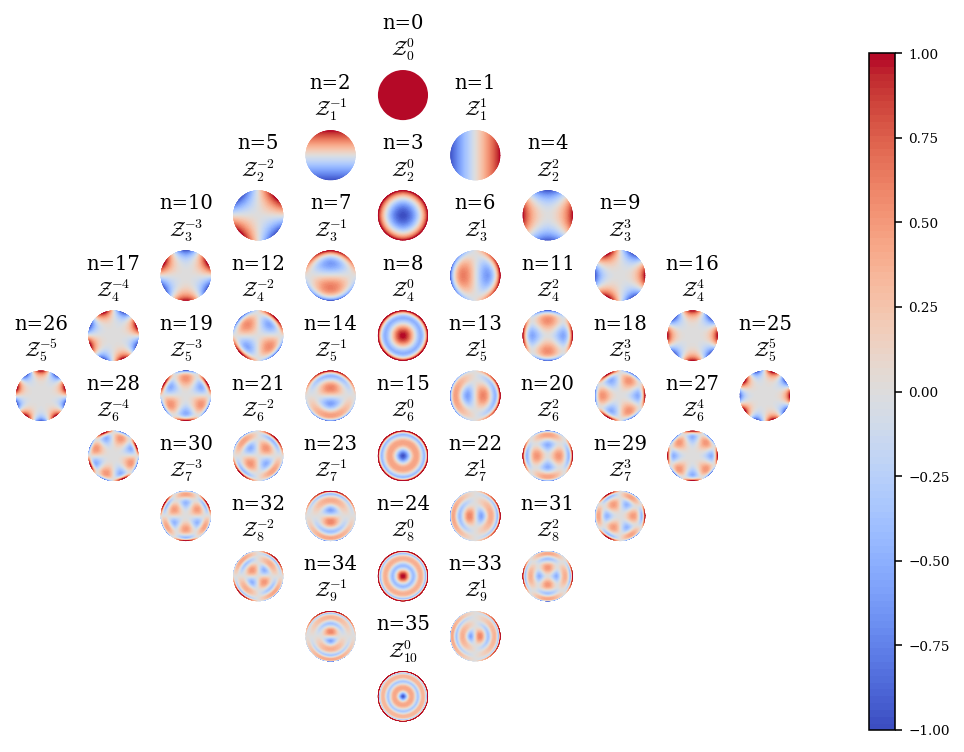

In [135]:
fig = plt.figure(figsize=(9,6))

mmax = 5
npts = 100
# nlm = (mmax+1)*(mmax+2)//2
nlm = (mmax+1)**2
lm = np.array([fringe_to_lm(i) for i in range(nlm)])
levels = np.linspace(-1,1,npts)
lmax = np.max(lm[:,0])
ax = {i:{} for i in range(lmax+1)}
gs = matplotlib.gridspec.GridSpec(lmax+1, 2*(mmax+1)) 
for l,m in lm:
    r = np.linspace(0,1,npts)
    v = np.linspace(0,2*jnp.pi,npts)
    rr,vv = np.meshgrid(r,v,indexing='ij')
    Z = zern(rr.flatten(),vv.flatten(),l,m,0,0).reshape((npts,npts))
    
    ax[l][m] = plt.subplot(gs[l,m+mmax:m+mmax+2],projection='polar')
    ax[l][m].set_title('n=' + str(lm_to_fringe(l,m)) + '\n$\mathcal{Z}_{' + str(l) + '}^{' + str(m) + '}$')
    ax[l][m].axis('off')
    im = ax[l][m].contourf(v,r,Z,levels=levels,cmap='coolwarm')
#     ax[l][m].plot(v,jnp.ones_like(v),lw=2,c='k')

cb_ax = fig.add_axes([0.83, 0.1, 0.02, 0.8])
plt.subplots_adjust(right=.8)
cbar = fig.colorbar(im, cax=cb_ax)
cbar.set_ticks(np.linspace(-1, 1, 9))

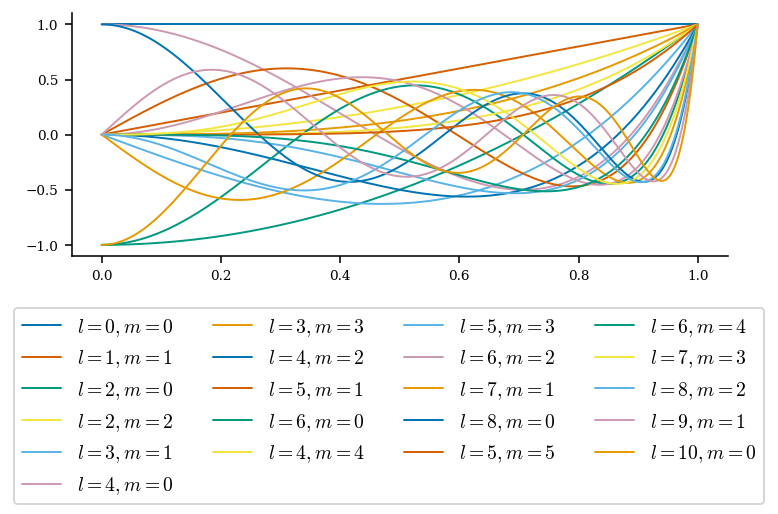

In [136]:
fig, ax = plt.subplots()

mmax = 5
npts = 1000
# nlm = (mmax+1)*(mmax+2)//2
nlm = (mmax+1)**2
lm = np.array([fringe_to_lm(i) for i in range(nlm)])
r = np.linspace(0,1,npts)

for l,m in lm:
    if (l-m)%2 == 0 and m>=0:
        ax.plot(r,zern_radial(r,l,m),lw=1,label='$l={},m={}$'.format(l,m))
plt.subplots_adjust(bottom=.45)
fig.legend(ncol=4, loc='lower center',)

In [137]:
def get_initial_guess_scale_bdry(bdryR,bdryZ,poloidal,toroidal,zern_idx,NFP,mode,nr=20,rcond=1e-6):
    """Generate initial guess by scaling boundary shape
    
    Args:
        bdryR (ndarray, shape(N_bdry_vals,)): R coordinates of boundary, or spectral coefficients of boundary R shape
        bdryZ (ndarray, shape(N_bdry_vals,)): Z coordinates of boundary, or spectral coefficients of boundary Z shape
        poloidal (ndarray, shape(N_bdry_vals,)): poloidal coordinates where bdryR,bdryZ are given, or poloidal mode numbers
        toroidal (ndarray, shape(N_bdry_vals,)): toroidal coordinates where bdryR,bdryZ are given, or toroidal mode numbers
        zern_idx (ndarray, shape(Nc,3)): indices for spectral basis, ie an array of [l,m,n] for each spectral coefficient
        NFP (int): number of field periods
        mode (str): one of 'real', 'spectral' - which format is being used for bdryR,bdryZ,poloidal,toroidal
        nr (int): number of radial points to use when generating guess
        rcond (float): relative limit on singular values for least squares fit to Zernike basis
    Returns:
        cR (ndarray, shape(N_coeffs,)): Fourier-Zernike coefficients for R, following indexing given in zern_idx
        cZ (ndarray, shape(N_coeffs,)): Fourier-Zernike coefficients for Z, following indexing given in zern_idx
    """
    if mode == 'spectral':
        # convert to real space by evaluating spectral coefficients on grid in theta, phi
        dimFourN = 2*np.max(np.abs(toroidal))+1
        dv = np.pi/64
        dz = 2*np.pi/(NFP*dimFourN)
        bdry_theta = np.arange(0,2*np.pi,dv)
        bdry_phi = np.arange(0,2*np.pi/NFP,dz)
        bdry_theta, bdry_phi = np.meshgrid(bdry_theta,bdry_phi,indexing='ij')
        bdry_theta = bdry_theta.flatten()
        bdry_phi = bdry_phi.flatten()
        bdry_idx = np.stack([poloidal,toroidal]).T
        bdryR = eval_double_fourier(bdryR,bdry_idx,NFP,bdry_theta,bdry_phi)
        bdryZ = eval_double_fourier(bdryZ,bdry_idx,NFP,bdry_theta,bdry_phi)
    else:
        bdry_theta = poloidal
        bdry_phi = toroidal
        
    # set up grid for zernike basis
    r = np.linspace(1e-2,1,nr)
    rr,tt = np.meshgrid(r,bdry_theta,indexing='ij')
    rr,pp = np.meshgrid(r,bdry_phi,indexing='ij')
    rr = rr.flatten()
    tt = tt.flatten()
    pp = pp.flatten()
    vv = np.pi - tt
    zz = -pp
    zernt = ZernikeTransform([rr,vv,zz],zern_idx,NFP,derivatives=[0,0,0])
    
    # estimate axis location as center of bdry
    R0_est = (np.max(bdryR) + np.min(bdryR))/2
    Z0_est = (np.max(bdryZ) + np.min(bdryZ))/2

    # scale boundary
    Rinit = (r[:,np.newaxis]*(bdryR[np.newaxis,:]-R0_est) + R0_est).flatten()
    Zinit = (r[:,np.newaxis]*(bdryZ[np.newaxis,:]-Z0_est) + Z0_est).flatten()

    # fit to zernike basis for initial guess
    cR = zernt.fit(Rinit,rcond).flatten()
    cZ = zernt.fit(Zinit,rcond).flatten()
    
    return cR, cZ

In [138]:
def eval_four_zern(c,idx,NFP,rho,theta,zeta,dr=0,dv=0,dz=0):
    """Evaluates Fourier-Zernike basis function at a point
    
    Args:
        c (ndarray, shape(Nc,)): spectral cofficients
        idx (ndarray, shape(Nc,3)): indices for spectral basis, ie an array of [l,m,n] for each spectral coefficient
        NFP (int): number of field periods
        rho (float,array-like): radial coordinates to evaluate
        theta (float,array-like): poloidal coordinates to evaluate
        zeta (float,array-like): toroidal coordinates to evaluate
        dr,dv,dz (int): order of derivatives to take in rho,theta,zeta

    Returns:
        f (ndarray): function evaluated at specified points
    """
    idx = jnp.atleast_2d(idx)
    rho = jnp.asarray(rho)
    theta = jnp.asarray(theta)
    zeta = jnp.asarray(zeta)
    Z = jnp.stack([fourzern(rho,theta,zeta,lmn[0],lmn[1],lmn[2],NFP,dr,dv,dz) for lmn in idx]).T 
    Z = jnp.atleast_2d(Z)
    f = jnp.matmul(Z,c)
    return f

In [139]:
@conditional_decorator(functools.partial(jit), use_jax)
def eval_double_fourier(c,idx,NFP,theta,phi):
    """Evaluates double fourier series F = sum(F_mn(theta,phi))
    
    Where F_mn(theta,phi) = f_mn*cos(m*theta)*sin(n*phi)
    
    Args:
        c (ndarray, shape(Nc,): spectral coefficients for double fourier series
        idx (ndarray of int, shape(Nc,2)): mode numbers for spectral basis. idx[i,0] = m, idx[i,1] = n
        NFP (int): number of field periods
        theta (ndarray, shape(n,)): theta values where to evaluate
        phi (ndarray, shape(n,)): phi values where to evaluate
    
    Returns:
        F (ndarray, size(n,)): F(theta,phi) evaluated at specified points
    """

    c = c.flatten()
    f = jnp.zeros_like(theta)
    for k, cc in enumerate(c):
        m = idx[k,0]
        n = idx[k,1]
        f = f + cc*double_fourier_basis(theta,phi,m,n,NFP)
        
    return f

In [140]:
@conditional_decorator(functools.partial(jit,static_argnums=(3,4,7,8,9)), use_jax)
def compute_bc_err_four(cR,cZ,cL,zern_idx,lambda_idx,bdryR,bdryZ,bdryM,bdryN,NFP):
    """Compute boundary error in fourier coefficients
    
    Args:
        cR (ndarray, shape(N_coeffs,)): Fourier-Zernike coefficients of R
        cZ (ndarray, shape(N_coeffs,)): Fourier-Zernike coefficients of Z
        cL (ndarray, shape(2M+1)*(2N+1)): double Fourier coefficients of lambda
        zern_idx (ndarray, shape(Nc,3)): indices for R,Z spectral basis, ie an array of [l,m,n] for each spectral coefficient
        lambda_idx (ndarray, shape(Nlambda,2)): indices for lambda spectral basis, ie an array of [m,n] for each spectral coefficient
        bdryR (ndarray, shape(N_bdry_modes,)): R coefficients of boundary shape
        bdryZ (ndarray, shape(N_bdry_modes,)): Z coefficients of boundary shape
        bdryM (ndarray, shape(N_bdry_modes,)): poloidal mode numbers
        bdryN (ndarray, shape(N_bdry_modes,)): toroidal mode numbers
        NFP (int): number of field periods   
        
    Returns:
        errR ((ndarray, shape(N_bdry_pts,))): vector of R errors in boundary spectral coeffs
        errZ ((ndarray, shape(N_bdry_pts,))): vector of Z errors in boundary spectral coeffs
    """
    
    # get grid for bdry eval
    dimFourN = 2*jnp.max(jnp.abs(bdryN))+1
    dv = jnp.pi/64
    dz = 2*jnp.pi/(NFP*dimFourN)
    bdry_theta = jnp.arange(0,2*jnp.pi,dv)
    bdry_phi = jnp.arange(0,2*jnp.pi/NFP,dz)
    bdry_theta, bdry_phi = jnp.meshgrid(bdry_theta,bdry_phi,indexing='ij')
    bdry_theta = bdry_theta.flatten()
    bdry_phi = bdry_phi.flatten()

    L = eval_double_fourier(cL,lambda_idx,NFP,bdry_theta,bdry_phi)

    # find values of R,Z at pts specified
    rho = jnp.ones_like(bdry_theta)
    vartheta = jnp.pi - bdry_theta + L
    zeta = -bdry_phi
    zern_bdry_interp = jnp.stack([fourzern(rho,vartheta,zeta,lmn[0],lmn[1],lmn[2],NFP,0,0,0) for lmn in zern_idx]).T
    R = jnp.matmul(zern_bdry_interp,cR).flatten()
    Z = jnp.matmul(zern_bdry_interp,cZ).flatten()

    four_bdry_interp = jnp.stack([double_fourier_basis(bdry_theta,bdry_phi,m,n,NFP) for m, n in zip(bdryM,bdryN)]).T

    cRb, cZb = jnp.linalg.lstsq(four_bdry_interp,jnp.array([R,Z]).T)[0].T

    # compute errors
    errR = cRb - bdryR
    errZ = cZb - bdryZ
    return errR,errZ

In [141]:
@conditional_decorator(functools.partial(jit,static_argnums=(3,4,7,8,9)), use_jax)
def compute_bc_err_RZ(cR,cZ,cL,zern_idx,lambda_idx,bdryR,bdryZ,bdry_theta,bdry_phi,NFP):
    """Compute boundary error at discrete points
    
    Args:
        cR (ndarray, shape(N_coeffs,)): Fourier-Zernike coefficients of R
        cZ (ndarray, shape(N_coeffs,)): Fourier-Zernike coefficients of Z
        cL (ndarray, shape(2M+1)*(2N+1)): double Fourier coefficients of lambda
        zern_idx (ndarray, shape(Nc,3)): indices for R,Z spectral basis, ie an array of [l,m,n] for each spectral coefficient
        lambda_idx (ndarray, shape(Nlambda,2)): indices for lambda spectral basis, ie an array of [m,n] for each spectral coefficient
        bdryR (ndarray, shape(N_bdry_pts,)): R values of boundary shape
        bdryZ (ndarray, shape(N_bdry_pts,)): Z values of boundary shape
        bdry_theta (ndarray, shape(N_bdry_pts,)): real space poloidal coordinates where boundary is specified
        bdry_phi (ndarray, shape(N_bdry_pts,)): real space toroidal coordinates where boundary is specified
        NFP (int): number of field periods   
        
    Returns:
        errR ((ndarray, shape(N_bdry_pts,))): vector of R errors in boundary position at specified points
        errZ ((ndarray, shape(N_bdry_pts,))): vector of Z errors in boundary position at specified points
    """


    L = eval_double_fourier(cL,lambda_idx,NFP,bdry_theta,bdry_phi)

    # find values of R,Z at pts specified
    rho = jnp.ones_like(bdry_theta)
    vartheta = jnp.pi - bdry_theta + L
    zeta = -bdry_phi
    zern_bdry_interp = jnp.stack([fourzern(rho,vartheta,zeta,lmn[0],lmn[1],lmn[2],NFP,0,0,0) for lmn in zern_idx]).T
    R = jnp.matmul(zern_bdry_interp,cR).flatten()
    Z = jnp.matmul(zern_bdry_interp,cZ).flatten()

    # compute errors
    errR = R-bdryR
    errZ = Z-bdryZ
    
    return errR,errZ

In [142]:
@conditional_decorator(functools.partial(jit,static_argnums=(1,2)), use_jax)
def compute_lambda_err(cL,idx,NFP):
    """Compute the error in sum(lambda_mn) to enforce 
    vartheta(0,0) = 0
    
    Args:
        cL (ndarray, shape(2M+1)*(2N+1)): double Fourier coefficients of lambda
        idx (ndarray, shape(Nlambda,2)): indices for lambda spectral basis, ie an array of [m,n] for each spectral coefficient
        NFP (int): number of field periods 
        
    Returns:
        errL (float): sum of lambda_mn where m,n>0
    """
    
    mn_pos = jnp.where(jnp.logical_and(idx[:,0]>=0, idx[:,1]>=0))[0]
    errL = jnp.sum(cL[mn_pos])
            
    return errL

In [143]:
def get_lambda_constraint_matrix(zern_idx,lambda_idx):
    """Computes a linear constraint matrix to enforce vartheta(0,0) = 0
    We require sum(lambda_mn) = 0, is Cx = 0
    
    Args:
        zern_idx (ndarray, shape(Nc,3)): indices for R,Z spectral basis, ie an array of [l,m,n] for each spectral coefficient
        lambda_idx (ndarray, shape(Nlambda,2)): indices for lambda spectral basis, ie an array of [m,n] for each spectral coefficient
        
    Returns:
        C (ndarray, shape(2*N_coeffs + (2M+1)*(2N+1))): linear constraint matrix, so Cx is the error 
            in the lambda constraint
    """
    
    # assumes x = [cR, cZ, cL]
    offset = 2*len(zern_idx)
    mn_pos = np.where(np.logical_and(lambda_idx[:,0]>=0, lambda_idx[:,1]>=0))[0]
    C = np.zeros(offset + len(lambda_idx))
    C[offset+mn_pos] = 1
            
    return C


In [144]:
@conditional_decorator(functools.partial(jit,static_argnums=(2)), use_jax)
def compute_coordinate_derivatives(cR,cZ,zernt):
    """Converts from spectral to real space and evaluates derivatives of R,Z wrt to SFL coords
    
    Args:
        cR (ndarray, shape(N_coeffs,)): spectral coefficients of R
        cZ (ndarray, shape(N_coeffs,)): spectral coefficients of Z
        zernt (ZernikeTransform): object with transform method to go from spectral to physical space with derivatives
    
    Returns:
        coordinate_derivatives (dict): dictionary of ndarray, shape(N_nodes,) of coordinate derivatives evaluated at node locations
    """
    # notation: X_y means derivative of X wrt y
    coordinate_derivatives = {}
    coordinate_derivatives['R'] = zernt.transform(cR,0,0,0)
    coordinate_derivatives['Z'] = zernt.transform(cZ,0,0,0)
    coordinate_derivatives['0'] = jnp.zeros_like(coordinate_derivatives['R'])
    
    coordinate_derivatives['R_r'] = zernt.transform(cR,1,0,0)
    coordinate_derivatives['Z_r'] = zernt.transform(cZ,1,0,0)
    coordinate_derivatives['R_v'] = zernt.transform(cR,0,1,0)
    coordinate_derivatives['Z_v'] = zernt.transform(cZ,0,1,0)
    coordinate_derivatives['R_z'] = zernt.transform(cR,0,0,1)
    coordinate_derivatives['Z_z'] = zernt.transform(cZ,0,0,1)

    coordinate_derivatives['R_rr'] = zernt.transform(cR,2,0,0)
    coordinate_derivatives['Z_rr'] = zernt.transform(cZ,2,0,0)
    coordinate_derivatives['R_rv'] = zernt.transform(cR,1,1,0)
    coordinate_derivatives['Z_rv'] = zernt.transform(cZ,1,1,0)
    coordinate_derivatives['R_rz'] = zernt.transform(cR,1,0,1)
    coordinate_derivatives['Z_rz'] = zernt.transform(cZ,1,0,1)

    coordinate_derivatives['R_vr'] = zernt.transform(cR,1,1,0)
    coordinate_derivatives['Z_vr'] = zernt.transform(cZ,1,1,0)
    coordinate_derivatives['R_vv'] = zernt.transform(cR,0,2,0)
    coordinate_derivatives['Z_vv'] = zernt.transform(cZ,0,2,0)
    coordinate_derivatives['R_vz'] = zernt.transform(cR,0,1,1)
    coordinate_derivatives['Z_vz'] = zernt.transform(cZ,0,1,1)

    coordinate_derivatives['R_zr'] = zernt.transform(cR,1,0,1)
    coordinate_derivatives['Z_zr'] = zernt.transform(cZ,1,0,1)
    coordinate_derivatives['R_zv'] = zernt.transform(cR,0,1,1)
    coordinate_derivatives['Z_zv'] = zernt.transform(cZ,0,1,1)
    coordinate_derivatives['R_zz'] = zernt.transform(cR,0,0,2)
    coordinate_derivatives['Z_zz'] = zernt.transform(cZ,0,0,2)

    coordinate_derivatives['R_rrv'] = zernt.transform(cR,2,1,0)
    coordinate_derivatives['Z_rrv'] = zernt.transform(cZ,2,1,0)
    coordinate_derivatives['R_rvv'] = zernt.transform(cR,1,2,0)
    coordinate_derivatives['Z_rvv'] = zernt.transform(cZ,1,2,0)
    coordinate_derivatives['R_zrv'] = zernt.transform(cR,1,1,1)
    coordinate_derivatives['Z_zrv'] = zernt.transform(cZ,1,1,1)

    coordinate_derivatives['R_rrvv'] = zernt.transform(cR,2,2,0)
    coordinate_derivatives['Z_rrvv'] = zernt.transform(cZ,2,2,0)

    return coordinate_derivatives

In [145]:
@conditional_decorator(functools.partial(jit), use_jax)
def compute_covariant_basis(coordinate_derivatives):
    """Computes covariant basis vectors at grid points
    
    Args:
        coordinate_derivatives (dict): dictionary of ndarray, shape(N_nodes,) of the coordinate derivatives at each node
        
    Returns:
        covariant_basis (dict): dictionary of ndarray, shape(N_nodes,) of covariant basis vectors and derivatives at each node
    """
    # notation: subscript word is direction of unit vector, subscript letters denote partial derivatives
    # eg, e_rho_v is the v derivative of the covariant basis vector in the rho direction
    cov_basis = {}
    cov_basis['e_rho']      = jnp.array([coordinate_derivatives['R_r'],  coordinate_derivatives['0'],   coordinate_derivatives['Z_r']])
    cov_basis['e_theta']    = jnp.array([coordinate_derivatives['R_v'],  coordinate_derivatives['0'],   coordinate_derivatives['Z_v']])
    cov_basis['e_zeta']     = jnp.array([coordinate_derivatives['R_z'], -coordinate_derivatives['R'],   coordinate_derivatives['Z_z']])

    cov_basis['e_rho_r']    = jnp.array([coordinate_derivatives['R_rr'], coordinate_derivatives['0'],   coordinate_derivatives['Z_rr']])
    cov_basis['e_rho_v']    = jnp.array([coordinate_derivatives['R_rv'], coordinate_derivatives['0'],   coordinate_derivatives['Z_rv']])
    cov_basis['e_rho_z']    = jnp.array([coordinate_derivatives['R_rz'], coordinate_derivatives['0'],   coordinate_derivatives['Z_rz']])

    cov_basis['e_theta_r']  = jnp.array([coordinate_derivatives['R_vr'], coordinate_derivatives['0'],   coordinate_derivatives['Z_vr']])
    cov_basis['e_theta_v']  = jnp.array([coordinate_derivatives['R_vv'], coordinate_derivatives['0'],   coordinate_derivatives['Z_vv']])
    cov_basis['e_theta_z']  = jnp.array([coordinate_derivatives['R_vz'], coordinate_derivatives['0'],   coordinate_derivatives['Z_vz']])

    cov_basis['e_zeta_r']  = jnp.array([coordinate_derivatives['R_zr'], -coordinate_derivatives['R_r'], coordinate_derivatives['Z_zr']])
    cov_basis['e_zeta_v']  = jnp.array([coordinate_derivatives['R_zv'], -coordinate_derivatives['R_v'], coordinate_derivatives['Z_zv']])
    cov_basis['e_zeta_z']  = jnp.array([coordinate_derivatives['R_zz'], -coordinate_derivatives['R_z'], coordinate_derivatives['Z_zz']])

    cov_basis['e_rho_vv']  = jnp.array([coordinate_derivatives['R_rvv'], coordinate_derivatives['0'],   coordinate_derivatives['Z_rvv']])
    cov_basis['e_rho_vz']  = jnp.array([coordinate_derivatives['R_zrv'], coordinate_derivatives['0'],   coordinate_derivatives['Z_zrv']])
    cov_basis['e_zeta_rv'] = jnp.array([coordinate_derivatives['R_zrv'],-coordinate_derivatives['R_rv'],coordinate_derivatives['Z_zrv']])
    
    return cov_basis

In [146]:
@conditional_decorator(functools.partial(jit), use_jax)
def compute_jacobian(coordinate_derivatives,covariant_basis):
    """Computes coordinate jacobian and derivatives
    
    Args:
        coordinate_derivatives (dict): dictionary of ndarray, shape(N_nodes,) of coordinate derivatives evaluated at node locations
        covariant_basis (dict): dictionary of ndarray, shape(N_nodes,) of covariant basis vectors and derivatives at each node 
        
    Returns:
        jacobian (dict): dictionary of ndarray, shape(N_nodes,) of coordinate jacobian and partial derivatives
    """
    # notation: subscripts denote partial derivatives
    jacobian = {}    
    jacobian['g'] = dot(covariant_basis['e_rho'] , cross(covariant_basis['e_theta'],covariant_basis['e_zeta'],0),0)

    jacobian['g_r'] = dot(covariant_basis['e_rho_r'],cross(covariant_basis['e_theta'],covariant_basis['e_zeta'],0),0) \
                      + dot(covariant_basis['e_rho'],cross(covariant_basis['e_rho_v'],covariant_basis['e_zeta'],0),0) \
                      + dot(covariant_basis['e_rho'],cross(covariant_basis['e_theta'],covariant_basis['e_zeta_r'],0),0)
    jacobian['g_v'] = dot(covariant_basis['e_rho_v'],cross(covariant_basis['e_theta'],covariant_basis['e_zeta'],0),0) \
                      + dot(covariant_basis['e_rho'],cross(covariant_basis['e_theta_v'],covariant_basis['e_zeta'],0),0) \
                      + dot(covariant_basis['e_rho'],cross(covariant_basis['e_theta'],covariant_basis['e_zeta_v'],0),0)
    jacobian['g_z'] = dot(covariant_basis['e_rho_z'],cross(covariant_basis['e_theta'],covariant_basis['e_zeta'],0),0) \
                      + dot(covariant_basis['e_rho'],cross(covariant_basis['e_theta_z'],covariant_basis['e_zeta'],0),0) \
                      + dot(covariant_basis['e_rho'],cross(covariant_basis['e_theta'],covariant_basis['e_zeta_z'],0),0)
    # need these later for rho=0
    jacobian['g_rr']  = coordinate_derivatives['R']*(coordinate_derivatives['R_r']*coordinate_derivatives['Z_rrv'] 
                                                     - coordinate_derivatives['Z_r']*coordinate_derivatives['R_rrv']
                                                     + 2*coordinate_derivatives['R_rr']*coordinate_derivatives['Z_rv']
                                                     - 2*coordinate_derivatives['R_rv']*coordinate_derivatives['Z_rr']) \
                                        + 2*coordinate_derivatives['R_r']*(coordinate_derivatives['Z_rv']*coordinate_derivatives['R_r']
                                                                           - coordinate_derivatives['R_rv']*coordinate_derivatives['Z_r'])
    jacobian['g_rv']  = coordinate_derivatives['R']*(coordinate_derivatives['Z_rvv']*coordinate_derivatives['R_r']
                                                     - coordinate_derivatives['R_rvv']*coordinate_derivatives['Z_r'])
    jacobian['g_zr']  = coordinate_derivatives['R_z']*(coordinate_derivatives['R_r']*coordinate_derivatives['Z_rv'] 
                                                       - coordinate_derivatives['R_rv']*coordinate_derivatives['Z_r']) \
                            + coordinate_derivatives['R']*(coordinate_derivatives['R_zr']*coordinate_derivatives['Z_rv'] 
                                                           + coordinate_derivatives['R_r']*coordinate_derivatives['Z_zrv']
                                                           - coordinate_derivatives['R_zrv']*coordinate_derivatives['Z_r']
                                                           - coordinate_derivatives['R_rv']*coordinate_derivatives['Z_zr'])
    jacobian['g_rrv'] = 2*coordinate_derivatives['R_rv']*(coordinate_derivatives['Z_rv']*coordinate_derivatives['R_r']
                                                          - coordinate_derivatives['R_rv']*coordinate_derivatives['Z_r']) \
                            + 2*coordinate_derivatives['R_r']*(coordinate_derivatives['Z_rvv']*coordinate_derivatives['R_r']
                                                               - coordinate_derivatives['R_rvv']*coordinate_derivatives['Z_r']) \
                            + coordinate_derivatives['R']*(coordinate_derivatives['R_r']*coordinate_derivatives['Z_rrvv']
                                                           - coordinate_derivatives['Z_r']*coordinate_derivatives['R_rrvv']
                                                           + 2*coordinate_derivatives['R_rr']*coordinate_derivatives['Z_rvv']
                                                           - coordinate_derivatives['R_rv']*coordinate_derivatives['Z_rrv']
                                                           - 2*coordinate_derivatives['Z_rr']*coordinate_derivatives['R_rvv']
                                                           + coordinate_derivatives['Z_rv']*coordinate_derivatives['R_rrv'])
    for key, val in jacobian.items():
        jacobian[key] = val.flatten()
    
    return jacobian

In [147]:
@conditional_decorator(functools.partial(jit,static_argnums=(0,2,3,5)), use_jax)
def compute_B_field(Psi_total, jacobian, nodes, axn, covariant_basis, iotafun_params):
    """Computes magnetic field at node locations
    
    Args:
        Psi_total (float): total toroidal flux within LCFS
        jacobian (dict): dictionary of ndarray, shape(N_nodes,) of coordinate jacobian and partial derivatives
        nodes (ndarray, shape(3,N_nodes)): array of node locations in rho, vartheta, zeta coordinates
        axn (array-like): indices of nodes at the magnetic axis
        covariant_basis (dict): dictionary of ndarray, shape(N_nodes,) of covariant basis vectors and derivatives at each node 
        iotafun_params (array-like): parameters to pass to rotational transform function   
    Return:
        B_field (dict): dictionary of ndarray, shape(N_nodes,) of magnetic field and derivatives
    """
    # notation: 1 letter subscripts denote derivatives, eg psi_rr = d^2 psi/dr^2
    # word sub or superscripts denote co and contravariant components of the field
    r = nodes[0]   
    iota = iotafun(r,0, iotafun_params)
    iotar = iotafun(r,1, iotafun_params)
    
    B_field = {}
    # B field
    B_field['psi'] = Psi_total*r**2 # could instead make Psi(r) an arbitrary function?
    B_field['psi_r']  = 2*Psi_total*r
    B_field['psi_rr'] = 2*Psi_total*jnp.ones_like(r)
    B_field['B^rho'] = jnp.zeros_like(r)
    B_field['B^zeta'] = B_field['psi_r'] / (2*jnp.pi*jacobian['g'])
    B_field['B^theta'] = iota * B_field['B^zeta']

    # B^{zeta} derivatives
    B_field['B^zeta_r'] = B_field['psi_rr'] / (2*jnp.pi*jacobian['g']) - (B_field['psi_r']*jacobian['g_r']) / (2*jnp.pi*jacobian['g']**2)
    B_field['B^zeta_v'] = - (B_field['psi_r']*jacobian['g_v']) / (2*jnp.pi*jacobian['g']**2)
    B_field['B^zeta_z'] = - (B_field['psi_r']*jacobian['g_z']) / (2*jnp.pi*jacobian['g']**2)
    # rho=0 terms only
    B_field['B^zeta_rv'] = B_field['psi_rr']*(2*jacobian['g_rr']*jacobian['g_rv'] 
                                              - jacobian['g_r']*jacobian['g_rrv']) / (4*jnp.pi*jacobian['g_r']**3)

    # magnetic axis
    B_field['B^zeta'] = put(B_field['B^zeta'], axn, Psi_total / (jnp.pi*jacobian['g_r'][axn]))
    B_field['B^theta'] = put(B_field['B^theta'], axn, Psi_total*iota[axn] / (jnp.pi*jacobian['g_r'][axn]))
    B_field['B^zeta_r'] = put(B_field['B^zeta_r'], axn, -(B_field['psi_rr'][axn]*jacobian['g_rr'][axn]) / (4*jnp.pi*jacobian['g_r'][axn]**2))
    B_field['B^zeta_v'] = put(B_field['B^zeta_v'], axn, 0)
    B_field['B^zeta_z'] = put(B_field['B^zeta_z'], axn, -(B_field['psi_rr'][axn]*jacobian['g_zr'][axn]) / (2*jnp.pi*jacobian['g_r'][axn]**2))

    # covariant B-component derivatives
    B_field['B_theta_r'] = B_field['B^zeta_r']*dot(iota*covariant_basis['e_theta']
                                                   +covariant_basis['e_zeta'],covariant_basis['e_theta'],0) \
                            + B_field['B^zeta']*dot(iotar*covariant_basis['e_theta']+iota*covariant_basis['e_rho_v']
                                                    +covariant_basis['e_zeta_r'],covariant_basis['e_theta'],0) \
                            + B_field['B^zeta']*dot(iota*covariant_basis['e_theta']+covariant_basis['e_zeta'],
                                                    covariant_basis['e_rho_v'],0)
    B_field['B_zeta_r'] = B_field['B^zeta_r']*dot(iota*covariant_basis['e_theta']+covariant_basis['e_zeta'],
                                                  covariant_basis['e_zeta'],0) \
                            + B_field['B^zeta']*dot(iotar*covariant_basis['e_theta']+iota*covariant_basis['e_rho_v']
                                                    +covariant_basis['e_zeta_r'],covariant_basis['e_zeta'],0) \
                            + B_field['B^zeta']*dot(iota*covariant_basis['e_theta']+covariant_basis['e_zeta'],
                                                    covariant_basis['e_zeta_r'],0)
    B_field['B_rho_v'] = B_field['B^zeta_v']*dot(iota*covariant_basis['e_theta']+covariant_basis['e_zeta'],
                                                 covariant_basis['e_rho'],0) \
                        + B_field['B^zeta']*dot(iota*covariant_basis['e_theta_v']+covariant_basis['e_zeta_v'],
                                                covariant_basis['e_rho'],0) \
                        + B_field['B^zeta']*dot(iota*covariant_basis['e_theta']+covariant_basis['e_zeta'],
                                                covariant_basis['e_rho_v'],0)
    B_field['B_zeta_v'] = B_field['B^zeta_v']*dot(iota*covariant_basis['e_theta']+covariant_basis['e_zeta'],
                                                  covariant_basis['e_zeta'],0) \
                            + B_field['B^zeta']*dot(iota*covariant_basis['e_theta_v']+covariant_basis['e_zeta_v'],
                                                    covariant_basis['e_zeta'],0) \
                            + B_field['B^zeta']*dot(iota*covariant_basis['e_theta']+covariant_basis['e_zeta'],
                                                    covariant_basis['e_zeta_v'],0)
    B_field['B_rho_z'] = B_field['B^zeta_z']*dot(iota*covariant_basis['e_theta']+covariant_basis['e_zeta'],
                                                 covariant_basis['e_rho'],0) \
                            + B_field['B^zeta']*dot(iota*covariant_basis['e_theta_z']+covariant_basis['e_zeta_z'],
                                                    covariant_basis['e_rho'],0) \
                            + B_field['B^zeta']*dot(iota*covariant_basis['e_theta']+covariant_basis['e_zeta'],
                                                    covariant_basis['e_rho_z'],0)
    B_field['B_theta_z'] = B_field['B^zeta_z']*dot(iota*covariant_basis['e_theta']+covariant_basis['e_zeta'],
                                                   covariant_basis['e_theta'],0) \
                            + B_field['B^zeta']*dot(iota*covariant_basis['e_theta_z']+covariant_basis['e_zeta_z'],
                                                    covariant_basis['e_theta'],0) \
                            + B_field['B^zeta']*dot(iota*covariant_basis['e_theta']+covariant_basis['e_zeta'],
                                                    covariant_basis['e_theta_z'],0)
    # need these later to evaluate axis terms
    B_field['B_zeta_rv'] = B_field['B^zeta_rv']*dot(covariant_basis['e_zeta'],covariant_basis['e_zeta'],0) \
                            + B_field['B^zeta']*dot(iota*covariant_basis['e_rho_vv']+2*covariant_basis['e_zeta_rv'],
                                                    covariant_basis['e_zeta'],0)
    B_field['B_theta_zr'] = B_field['B^zeta_z']*dot(covariant_basis['e_zeta'],covariant_basis['e_rho_v'],0) \
                            + B_field['B^zeta']*(dot(covariant_basis['e_zeta_z'],covariant_basis['e_rho_v'],0) \
                                                 + dot(covariant_basis['e_zeta'],covariant_basis['e_rho_vz'],0))

    for key, val in B_field.items():
        B_field[key] = val.flatten()

    return B_field

In [148]:
@conditional_decorator(functools.partial(jit,static_argnums=(2,3)), use_jax)
def compute_J_field(B_field, jacobian, nodes, axn):
    """Computes J from B
    (note it actually just computes curl(B), ie mu0*J)
    
    Args:
        B_field (dict): dictionary of ndarray, shape(N_nodes,) of magnetic field and derivatives    
        jacobian (dict): dictionary of ndarray, shape(N_nodes,) of coordinate jacobian and partial derivatives
        nodes (ndarray, shape(3,N_nodes)): array of node locations in rho, vartheta, zeta coordinates
        axn (array-like): indices of nodes at the magnetic axis
    
    Returns:
        J_field (dict): dictionary of ndarray, shape(N_nodes,) of current density vector at each node
    """
    # notation: superscript denotes contravariant component
    J_field = {}
    # contravariant J-components
    J_field['J^rho'] = (B_field['B_zeta_v'] - B_field['B_theta_z'])
    J_field['J^theta'] = (B_field['B_rho_z'] - B_field['B_zeta_r'])
    J_field['J^zeta'] = (B_field['B_theta_r'] - B_field['B_rho_v'])

    # axis terms
    J_field['J^rho'] = put(J_field['J^rho'], axn, (B_field['B_zeta_rv'][axn] - B_field['B_theta_zr'][axn]) / (jacobian['g_r'][axn]))
    
    for key, val in J_field.items():
        J_field[key] = val.flatten()
    
    return J_field

In [149]:
@conditional_decorator(functools.partial(jit,static_argnums=(3,4)), use_jax)
def compute_contravariant_basis(coordinate_derivatives, covariant_basis, jacobian, nodes, axn):
    """Computes contravariant basis vectors and jacobian elements
    
    Args:
        coordinate_derivatives (dict): dictionary of ndarray, shape(N_nodes,) of coordinate derivatives evaluated at node locations
        covariant_basis (dict): dictionary of ndarray, shape(N_nodes,) of covariant basis vectors and derivatives at each node 
        jacobian (dict): dictionary of ndarray, shape(N_nodes,) of coordinate jacobian and partial derivatives
        nodes (ndarray, shape(3,N_nodes)): array of node locations in rho, vartheta, zeta coordinates
        axn (array-like): indices of nodes at the magnetic axis

    Returns:
        contravariant_basis (dict): dictionary of ndarray, shape(N_nodes,) of contravariant basis vectors and jacobian elements
    
    """
    
    # notation: grad_x denotes gradient of x
    # superscript denotes contravariant component
    N_nodes = nodes[0].size
    r = nodes[0]
    
    contravariant_basis = {}
    # contravariant basis vectors
    contravariant_basis['grad_rho'] = cross(covariant_basis['e_theta'],
                                            covariant_basis['e_zeta'],0)/jacobian['g']  
    contravariant_basis['grad_theta'] = cross(covariant_basis['e_zeta'],
                                              covariant_basis['e_rho'],0)/jacobian['g']  
    contravariant_basis['grad_zeta'] = jnp.array([coordinate_derivatives['0'],
                                                 -1/coordinate_derivatives['R'],
                                                 coordinate_derivatives['0']])

    # axis terms. need some weird indexing because we're indexing into a 2d array with 
    # a 1d array of columns where we want to overwrite stuff
    # basically this gets the linear (flattened) indices we want to overwrite
    idx0 = jnp.ones((3,axn.size))
    idx1 = jnp.ones((3,axn.size))
    idx0 = (idx0*jnp.array([[0,1,2]]).T).flatten().astype(jnp.int32)
    idx1 = (idx1*axn).flatten().astype(jnp.int32)
    contravariant_basis['grad_rho'] = put(contravariant_basis['grad_rho'], (idx0,idx1), 
                                          (cross(covariant_basis['e_rho_v'][:,axn],
                                                 covariant_basis['e_zeta'][:,axn],0) / jacobian['g_r'][axn]).flatten())
    contravariant_basis['grad_theta'] = put(contravariant_basis['grad_theta'], (idx0,idx1), 
                                            (cross(covariant_basis['e_zeta'][:,axn],
                                                   covariant_basis['e_rho'][:,axn],0)).flatten())

    # just different names for the same thing
    contravariant_basis['e^rho'] = contravariant_basis['grad_rho']
    contravariant_basis['e^theta'] = contravariant_basis['grad_theta']
    contravariant_basis['e^zeta'] = contravariant_basis['grad_zeta']
    # metric coefficients
    contravariant_basis['g^rr'] = dot(contravariant_basis['grad_rho'],contravariant_basis['grad_rho'],0)
    contravariant_basis['g^vv'] = dot(contravariant_basis['grad_theta'],contravariant_basis['grad_theta'],0)  
    contravariant_basis['g^zz'] = dot(contravariant_basis['grad_zeta'],contravariant_basis['grad_zeta'],0)  
    contravariant_basis['g^vz'] = dot(contravariant_basis['grad_theta'],contravariant_basis['grad_zeta'],0)   
    
    return contravariant_basis

In [150]:
@conditional_decorator(functools.partial(jit,static_argnums=(2,3,4,5,6,7)), use_jax)
def compute_force_error_nodes(cR,cZ,zernt,nodes,pressfun_params,iotafun_params,Psi_total,node_volume):
    """Computes force balance error at each node
    
    Args:
        cR (ndarray, shape(N_coeffs,)): spectral coefficients of R
        cZ (ndarray, shape(N_coeffs,)): spectral coefficients of Z
        zernt (ZernikeTransform): object with tranform method to convert from spectral basis to physical basis at nodes
        pressfun_params (array-like): parameters to pass to pressure function
        iotafun_params (array-like): parameters to pass to rotational transform function
        Psi_total (float): total toroidal flux within LCFS
        node_volume (ndarray, shape(3,N_nodes)): arc length (dr,dv,dz) along each coordinate at each node, for computing volume.
        
    Returns:
        F_err (ndarray, shape(2*N_nodes,)): R,phi,Z components of force balance error at each grid point
    """
    N_nodes = nodes[0].size
    r = nodes[0]
    axn = jnp.where(r == 0)[0]
    # value of r one step out from axis
    r1 = jnp.min(r[r != 0])
    r1idx = jnp.where(r == r1)[0]
    
    pres = pressfun(r,0,pressfun_params)
    presr = pressfun(r,1, pressfun_params)

    # compute coordinates, fields etc.
    coordinate_derivatives = compute_coordinate_derivatives(cR,cZ,zernt)
    covariant_basis = compute_covariant_basis(coordinate_derivatives)
    jacobian = compute_jacobian(coordinate_derivatives,covariant_basis)
    B_field = compute_B_field(Psi_total, jacobian, nodes, axn, covariant_basis, iotafun_params)
    J_field = compute_J_field(B_field, jacobian, nodes, axn)
    contravariant_basis = compute_contravariant_basis(coordinate_derivatives, covariant_basis, jacobian, nodes, axn)

    # helical basis vector
    beta = B_field['B^zeta']*contravariant_basis['e^theta'] - B_field['B^theta']*contravariant_basis['e^zeta']

    # force balance error in radial and helical direction
    Frho = (J_field['J^theta']*B_field['B^zeta'] - J_field['J^zeta']*B_field['B^theta']) - presr
    Fbeta = J_field['J^rho']
    
    
    radial  = jnp.sqrt(contravariant_basis['g^rr']) * jnp.sign(dot(contravariant_basis['e^rho'],covariant_basis['e_rho'],0));
    helical = jnp.sqrt(contravariant_basis['g^vv']*B_field['B^zeta']**2 + contravariant_basis['g^zz']*B_field['B^theta']**2 \
               - 2*contravariant_basis['g^vz']*B_field['B^theta']*B_field['B^zeta']) * jnp.sign(
            dot(beta,covariant_basis['e_theta'],0))*jnp.sign(dot(beta,covariant_basis['e_zeta'],0));
    put(helical,axn,jnp.sqrt(contravariant_basis['g^vv'][axn]*B_field['B^zeta'][axn]**2) * jnp.sign(B_field['B^zeta'][axn]))

    
    # weight by local volume
    if node_volume is not None:
        vol = jacobian['g']*node_volume[0]*node_volume[1]*node_volume[2];
        vol = put(vol, axn, jnp.mean(jacobian['g'][r1idx])/2*node_volume[0,axn]*node_volume[1,axn]*node_volume[2,axn])
        Frho = Frho*vol
        Fbeta = Fbeta*vol
        
    F_err = jnp.concatenate([Frho*radial,Fbeta*helical])
 
    return F_err

In [151]:
def plot_coord_surfaces(cR,cZ,zern_idx,NFP,nr=20,ntheta=30,ax=None,bdryR=None,bdryZ=None):
    """Plots solutions (currently only zeta=0 plane)

    Args:
        cR (ndarray, shape(N_coeffs,)): spectral coefficients of R
        cZ (ndarray, shape(N_coeffs,)): spectral coefficients of Z
        zern_idx (ndarray, shape(Nc,3)): indices for R,Z spectral basis, ie an array of [l,m,n] for each spectral coefficient
        NFP (int): number of field periods
        nr (int): number of flux surfaces to show
        ntheta (int): number of theta lines to show
        ax (matplotlib.axes): axes to plot on. If None, a new figure is created.
    
    Returns:
        ax (matplotlib.axes): handle to axes used for the plot
    """           
        
    Nr = 100
    Ntheta = 100
    rstep = Nr//nr
    thetastep = Ntheta//ntheta
    r = np.linspace(0,1,Nr)
    theta = np.linspace(0,2*jnp.pi,Ntheta)
    rr,tt = np.meshgrid(r,theta,indexing='ij')
    rr = rr.flatten()
    tt = tt.flatten()
    zz = np.zeros_like(rr)
    zernt = ZernikeTransform([rr,tt,zz],zern_idx,NFP)

    R = zernt.transform(cR,0,0,0).reshape((Nr,Ntheta))
    Z = zernt.transform(cZ,0,0,0).reshape((Nr,Ntheta))

    if ax is None:
        fig, ax = plt.subplots()
    # plot desired bdry
    if bdryR is not None and bdryZ is not None:
        ax.plot(bdryR,bdryZ,color=colorblind_colors[1])
    # plot r contours
    ax.plot(R.T[:,::rstep],Z.T[:,::rstep],color=colorblind_colors[0],lw=.5)
    # plot actual bdry
    ax.plot(R.T[:,-1],Z.T[:,-1],color=colorblind_colors[0],lw=.5)
    # plot theta contours
    ax.plot(R[:,::thetastep],Z[:,::thetastep],color=colorblind_colors[0],lw=.5,ls='--');
    ax.axis('equal')
    ax.set_xlabel('$R$')
    ax.set_ylabel('$Z$')
    return ax

In [152]:
def plot_coeffs(cR,cZ,cL,zern_idx,lambda_idx,cR_init=None,cZ_init=None,cL_init=None):
    """Scatter plots of zernike and lambda coefficients, before and after solving
    
    Args:
        cR (ndarray, shape(N_coeffs,)): spectral coefficients of R
        cZ (ndarray, shape(N_coeffs,)): spectral coefficients of Z
        cL (ndarray, shape(2M+1)*(2N+1)): spectral coefficients of lambda
        zern_idx (ndarray, shape(N_coeffs,3)): array of (l,m,n) indices for each spectral R,Z coeff
        lambda_idx (ndarray, shape(Nlambda,2)): indices for lambda spectral basis, ie an array of [m,n] for each spectral coefficient        
        cR_init (ndarray, shape(N_coeffs,)): initial spectral coefficients of R
        cZ_init (ndarray, shape(N_coeffs,)): initial spectral coefficients of Z
        cL_init (ndarray, shape(2M+1)*(2N+1)): initial spectral coefficients of lambda
        
    Returns:
        fig (matplotlib.figure): handle to the figure
        ax (ndarray of matplotlib.axes): handle to axes
    """
    nRZ = len(cR)
    nL = len(cL)
    fig, ax = plt.subplots(1,3, figsize=(cR.size//5,6))
    ax = ax.flatten()

    ax[0].scatter(cR,np.arange(nRZ),s=2, label='Final')
    if cR_init is not None:
        ax[0].scatter(cR_init,np.arange(nRZ),s=2, label='Init')
    ax[0].set_yticks(np.arange(nRZ))
    ax[0].set_yticklabels([str(i) for i in zern_idx]);
    ax[0].set_xlabel('$R$')
    ax[0].set_ylabel('[l,m,n]')
    ax[0].axvline(0,c='k',lw=.25)
    ax[0].legend(loc='upper right')

    ax[1].scatter(cZ,np.arange(nRZ),s=2, label='Final')
    if cZ_init is not None:
        ax[1].scatter(cZ_init,np.arange(nRZ),s=2, label='Init')
    ax[1].set_yticks(np.arange(nRZ))
    ax[1].set_yticklabels([str(i) for i in zern_idx]);
    ax[1].set_xlabel('$Z$')
    ax[1].set_ylabel('[l,m,n]')
    ax[1].axvline(0,c='k',lw=.25)
    ax[1].legend()

    ax[2].scatter(cL,np.arange(nL),s=2, label='Final')
    if cL_init is not None:
        ax[2].scatter(cL_init,np.arange(nL),s=2, label='Init')
    ax[2].set_yticks(np.arange(nL))
    ax[2].set_yticklabels([str(i) for i in lambda_idx]);
    ax[2].set_xlabel('$\lambda$')
    ax[2].set_ylabel('[m,n]')
    ax[2].axvline(0,c='k',lw=.25)
    ax[2].legend()

    plt.subplots_adjust(wspace=.5)

    return fig, ax

In [153]:
def plot_fb_err(cR,cZ,cL,zern_idx,lambda_idx,NFP,iotafun_params, pressfun_params, Psi_total,
                domain='real', normalize='local',ax=None, log=False, cmap='plasma'):
    """Plots force balance error
    
    Args:
        cR (ndarray, shape(N_coeffs,)): spectral coefficients of R
        cZ (ndarray, shape(N_coeffs,)): spectral coefficients of Z
        cL (ndarray, shape(2M+1)*(2N+1)): spectral coefficients of lambda
        zern_idx (ndarray, shape(N_coeffs,3)): array of (l,m,n) indices for each spectral R,Z coeff
        lambda_idx (ndarray, shape(Nlambda,2)): indices for lambda spectral basis, ie an array of [m,n] for each spectral coefficient        
        NFP (int): number of field periods
        iotafun_params (array-like): paramters to pass to rotational transform function
        pressfun_params (array-like): parameters to pass to pressure function
        Psi_total (float): total toroidal flux in the plasma
        domain (str): one of 'real', 'sfl'. What basis to use for plotting, 
            real (R,Z) coordinates or straight field line (rho,vartheta)
        normalize (str, bool): Whether and how to normalize values
            None, False - no normalization, values plotted are force error in Newtons/m^3
            'local' - normalize by local pressure gradient
            'global' - normalize by pressure gradient at rho=0.5
            True - same as 'global'
        ax (matplotlib.axes): axes to use for plotting
        log (bool): plot logarithm of error or absolute value
        cmap (str,matplotlib.colors.Colormap): colormap to use
    
    Returns:
        ax (matplotlib.axes): handle to axes used for plotting
        im (TriContourSet): handle to contourf plot
    """

    if domain not in ['real','sfl']:
        raise ValueError("domain expected one of 'real', 'sfl'")
    if normalize not in ['local','global',None,True,False]:
        raise ValueError("normalize expected one of 'local','global',None,True")
    nr = 100
    ntheta = 100
    r = np.linspace(0,1,nr)
    t = np.linspace(0,2*np.pi,ntheta)
    z = 0
    rr,tt,zz = np.meshgrid(r,t,z,indexing='ij')
    rr = rr.flatten()
    tt = tt.flatten()
    zz = zz.flatten()
    L = eval_double_fourier(cL,lambda_idx,NFP,tt,zz)
    vv = np.pi - tt + L
    
    nodes = np.stack([rr,vv,zz])
    derivatives = get_needed_derivatives('force')
    zernt = ZernikeTransform(nodes,zern_idx,NFP,derivatives)
    axn = np.where(rr == 0)[0]
    halfn = np.where(rr == r[nr//2])[0]
    N_nodes = rr.size


    coordinate_derivatives = compute_coordinate_derivatives(cR,cZ,zernt)
    covariant_basis = compute_covariant_basis(coordinate_derivatives)
    jacobian = compute_jacobian(coordinate_derivatives,covariant_basis)
    contravariant_basis = compute_contravariant_basis(coordinate_derivatives, covariant_basis, jacobian, nodes, axn)

    errF = compute_force_error_nodes(cR,cZ,zernt,nodes,pressfun_params,iotafun_params,Psi_total,None)
    errF = errF.reshape((N_nodes,2),order='F')
    radial  = jnp.sqrt(contravariant_basis['g^rr']) * jnp.sign(dot(contravariant_basis['e^rho'],covariant_basis['e_rho'],0));
    press = pressfun(rr,1,pressfun_params)*radial

    if normalize == 'global' or normalize == True:
        norm_errF = np.linalg.norm(errF,axis=1)/rms(press[halfn])
    elif normalize == 'local':
        JxB = errF[:,0] + press
        norm_errF = np.linalg.norm(errF,axis=1)/(np.abs(JxB) + np.abs(press))
    else:
        mu0 = 4*np.pi*1e-7
        norm_errF = np.linalg.norm(errF/mu0,axis=1)
    
    if log:
        norm_errF = np.log10(norm_errF)
    if ax is None:
        fig, ax = plt.subplots()

    if domain == 'real':
        R = zernt.transform(cR,0,0,0)
        Z = zernt.transform(cZ,0,0,0)
        levels=100
        im = ax.tricontourf(R,Z,norm_errF,levels=levels,cmap=cmap)
        ax.set_xlabel(r'$R$')
        ax.set_ylabel(r'$Z$')
        ax.set_aspect('equal')
    elif domain == 'sfl':
        levels=100
        im = ax.tricontourf(tt,rr,norm_errF,levels=levels,cmap=cmap)
        ax.set_xticks([0,np.pi/2,np.pi,3/2*np.pi,2*np.pi])
        ax.set_xticklabels(['$0$',r'$\frac{\pi}{2}$',r'$\pi$',r'$\frac{3\pi}{2}$', r'$2\pi$'])
        ax.set_xlabel(r'$\theta$')
        ax.set_ylabel(r'$\rho$')
    
    if normalize == 'global' or normalize == True:
        title = '\\frac{||F||}{||\\nabla P(\\rho=0.5)||}' 
    elif normalize == 'local':
        title = '\\frac{||F||}{||\\nabla P||}' 
    else:
        title = '||F||'
    if log:
        title = 'log_{10} \\left(' + title + '\\right)'
    title = '$' + title + '$'
    ax.set_title(title)
    
    return ax, im

In [154]:
def plot_IC(cR_init, cZ_init, zern_idx, NFP, nodes, pressfun_params, iotafun_params):
    """Plot initial conditions, such as the initial guess for flux surfaces,
    node locations, and profiles.
    
    Args:
        cR_init (ndarray, shape(N_coeffs,)): spectral coefficients of R
        cZ_init (ndarray, shape(N_coeffs,)): spectral coefficients of Z
        zern_idx (ndarray, shape(N_coeffs,3)): array of (l,m,n) indices for each spectral R,Z coeff
        NFP (int): number of field periods
        iotafun_params (array-like): paramters to pass to rotational transform function
        pressfun_params (array-like): parameters to pass to pressure function

    Returns:
        fig (matplotlib.figure): handle to figure used for plotting
        ax (ndarray of matplotlib.axes): handles to axes used for plotting
    """    
    
    fig = plt.figure(figsize=(9,3))
    gs = matplotlib.gridspec.GridSpec(2, 3) 
    ax0 = plt.subplot(gs[:,0])
    ax1 = plt.subplot(gs[:,1],projection='polar')
    ax2 = plt.subplot(gs[0,2])
    ax3 = plt.subplot(gs[1,2])

    plot_coord_surfaces(cR_init,cZ_init,zern_idx,NFP,nr=20,ntheta=30,ax=ax0)
    ax0.axis('equal');
    ax0.set_title(r'Initial guess, $\zeta=0$ plane')
    ax1.plot(nodes[1],nodes[0],'o',markersize=1)
    ax1.set_xticks([0, np.pi/4, np.pi/2, 3/4*np.pi, 
                    np.pi, 5/4*np.pi, 3/2*np.pi, 7/4*np.pi])
    ax1.set_xticklabels(['$0$', r'$\frac{\pi}{4}$', r'$\frac{\pi}{2}$', r'$\frac{3\pi}{4}$',
                        r'$\pi$', r'$\frac{4\pi}{4}$', r'$\frac{3\pi}{2}$', r'$2\pi$'])
    ax1.set_yticklabels([])
    ax1.set_title(r'Node locations, $\zeta=0$ plane',pad=20)
    xx = np.linspace(0,1,100)
    ax2.plot(xx,pressfun(xx,0,pressfun_params),lw=1)
    ax2.set_ylabel(r'$\mu_0 P$')
    ax2.set_xticklabels([])
    ax2.set_title('Profiles')
    ax3.plot(xx,iotafun(xx,0,iotafun_params),lw=1)
    ax3.set_ylabel(r'$\iota$')
    ax3.set_xlabel(r'$\rho$')
    plt.subplots_adjust(wspace=0.5, hspace=0.3)
    
    return fig, ax

In [155]:
def dot(a,b,axis):
    """wrapper for vector dot product"""
    return jnp.sum(a*b,axis=axis,keepdims=False)

def sign(x):
    """sign function, but returns 1 for x==0"""
    y = jnp.sign(x)
    y = put(y,jnp.where(y.flatten()==0)[0],1)
    return y

def cross(a,b,axis):
    """wrapper for vector cross product with some error handling"""
    return jnp.cross(a,b,axis=axis)
  
def rms(x):
    """Compute rms value of an array"""
    return jnp.sqrt(jnp.mean(x**2))
    
def iotafun(rho,nu, params):
    """Rotational transform
    
    Args:
        rho (array-like): coordinates at which to evaluate
        nu (int): order of derivative (for compatibility with scipy spline routines)
        params (array-like): parameters to use for calculating profile
    """
    
    return jnp.polyval(jnp.polyder(params[::-1],nu),rho)
        
def pressfun(rho,nu, params):
    """Plasma pressure * mu0
    
    Args:
        rho (array-like): coordinates at which to evaluate
        nu (int): order of derivative (for compatibility with scipy spline routines)
        params (array-like): parameters to use for calculating profile
    """
    mu0 = 4*jnp.pi*1e-7

    return mu0*jnp.polyval(jnp.polyder(params[::-1],nu),rho)


def get_needed_derivatives(mode):
    if mode == 'force':
        return np.array([[0,0,0],[1,0,0],[0,1,0],[0,0,1],
                         [2,0,0],[1,1,0],[1,0,1],[0,2,0],
                         [0,1,1],[0,0,2],[2,1,0],[1,2,0],
                         [1,1,1],[2,2,0]])
    else:
        raise NotImplementedError

In [156]:
def unpack_x(x,zern_idx):
    """Unpacks the optimization state vector x into cR,cZ,cL components
    
    Args:
        x (ndarray): vector to unpack
        zern_idx (ndarray, shape(N_coeffs,3)): array of (l,m,n) indices for each spectral R,Z coeff
        
    Returns:
        cR (ndarray, shape(N_coeffs,)): spectral coefficients of R
        cZ (ndarray, shape(N_coeffs,)): spectral coefficients of Z
        cL (ndarray, shape(2M+1)*(2N+1)): spectral coefficients of lambda           
    """
    
    nRZ = len(zern_idx)
    cR = x[:nRZ]
    cZ = x[nRZ:2*nRZ]
    cL = x[2*nRZ:]
    return cR,cZ,cL

def axis_posn(cR,cZ,zern_idx,NFP):
    """Finds position of the magnetic axis (R0,Z0)
    
    Args:
        cR (ndarray, shape(N_coeffs,)): spectral coefficients of R
        cZ (ndarray, shape(N_coeffs,)): spectral coefficients of Z
        zern_idx (ndarray, shape(N_coeffs,3)): array of (l,m,n) indices for each spectral R,Z coeff
        NFP (int): number of field periods
        
    Returns:
        R0 (float): R coordinate of the magnetic axis in the zeta=0 plane
        Z0 (float): Z coordinate of the magnetic axis in the zeta=0 plane
    """
    R0 = eval_four_zern(cR,zern_idx,NFP,0.,0.,0.,dr=0,dv=0,dz=0)[0]
    Z0 = eval_four_zern(cZ,zern_idx,NFP,0.,0.,0.,dr=0,dv=0,dz=0)[0]
    
    return R0,Z0

In [161]:
N_nodes = nodes[0].size
r = nodes[0]
axn = jnp.where(r == 0)[0]
# value of r one step out from axis
r1 = np.min(r[r != 0])
r1idx = np.where(r == r1)[0]

pres = pressfun(r,0,pressfun_params)
presr = pressfun(r,1, pressfun_params)

# compute coordinates, fields etc.
coordinate_derivatives = compute_coordinate_derivatives(cR,cZ,zernt)
covariant_basis = compute_covariant_basis(coordinate_derivatives)
jacobian = compute_jacobian(coordinate_derivatives,covariant_basis)
B_field = compute_B_field(Psi_total, jacobian, nodes, axn, covariant_basis, iotafun_params)
J_field = compute_J_field(B_field, jacobian, nodes, axn)
contravariant_basis = compute_contravariant_basis(coordinate_derivatives, covariant_basis, jacobian, nodes, axn)

# helical basis vector
beta = B_field['B^zeta']*contravariant_basis['e^theta'] - B_field['B^theta']*contravariant_basis['e^zeta']

# force balance error in radial and helical direction
Frho = (J_field['J^theta']*B_field['B^zeta'] - J_field['J^zeta']*B_field['B^theta']) - presr
Fbeta = J_field['J^rho']

radial  = jnp.sqrt(contravariant_basis['g^rr']) * jnp.sign(dot(contravariant_basis['e^rho'],covariant_basis['e_rho'],0));
helical = jnp.sqrt(contravariant_basis['g^vv']*B_field['B^zeta']**2 + contravariant_basis['g^zz']*B_field['B^theta']**2 \
               - 2*contravariant_basis['g^vz']*B_field['B^theta']*B_field['B^zeta']) * sign(
    dot(beta,covariant_basis['e_theta'],0))*sign(dot(beta,covariant_basis['e_zeta'],0));
put(helical,axn,jnp.sqrt(contravariant_basis['g^vv'][axn]*B_field['B^zeta'][axn]**2) * sign(B_field['B^zeta'][axn]))

F_err = jnp.concatenate([Frho*radial,Fbeta*helical])


# force balance error in R,phi,Z
# F_err = Frho*contravariant_basis['grad_rho'] + Fbeta*beta

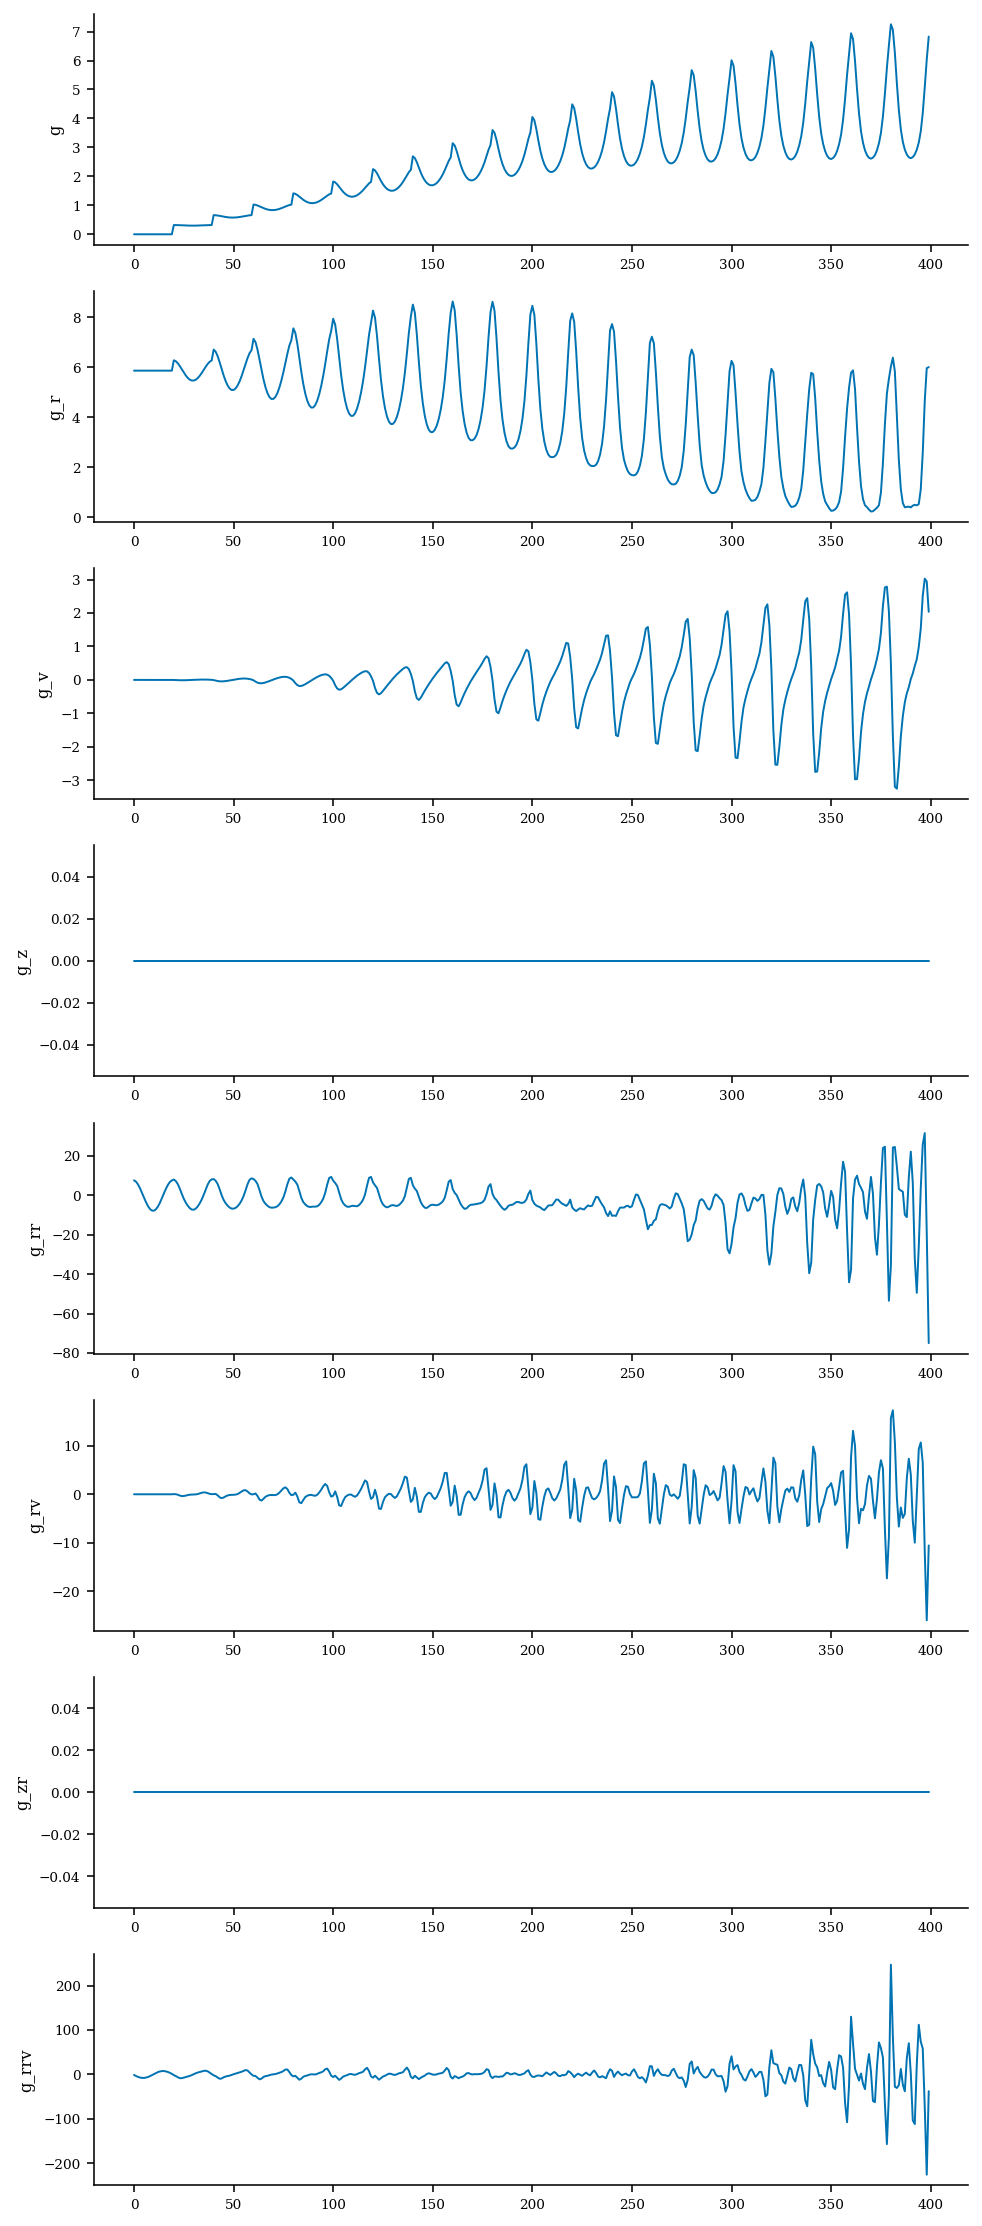

In [162]:
data = jacobian
fig, ax = plt.subplots(len(data),figsize=(8,20))

for i,(key,val) in enumerate(data.items()):
    if val.ndim >1:
        val = val.T
    ax[i].plot(val,lw=1)
    ax[i].set_ylabel(key)
    if np.any(np.isnan(val)):
        print(key)

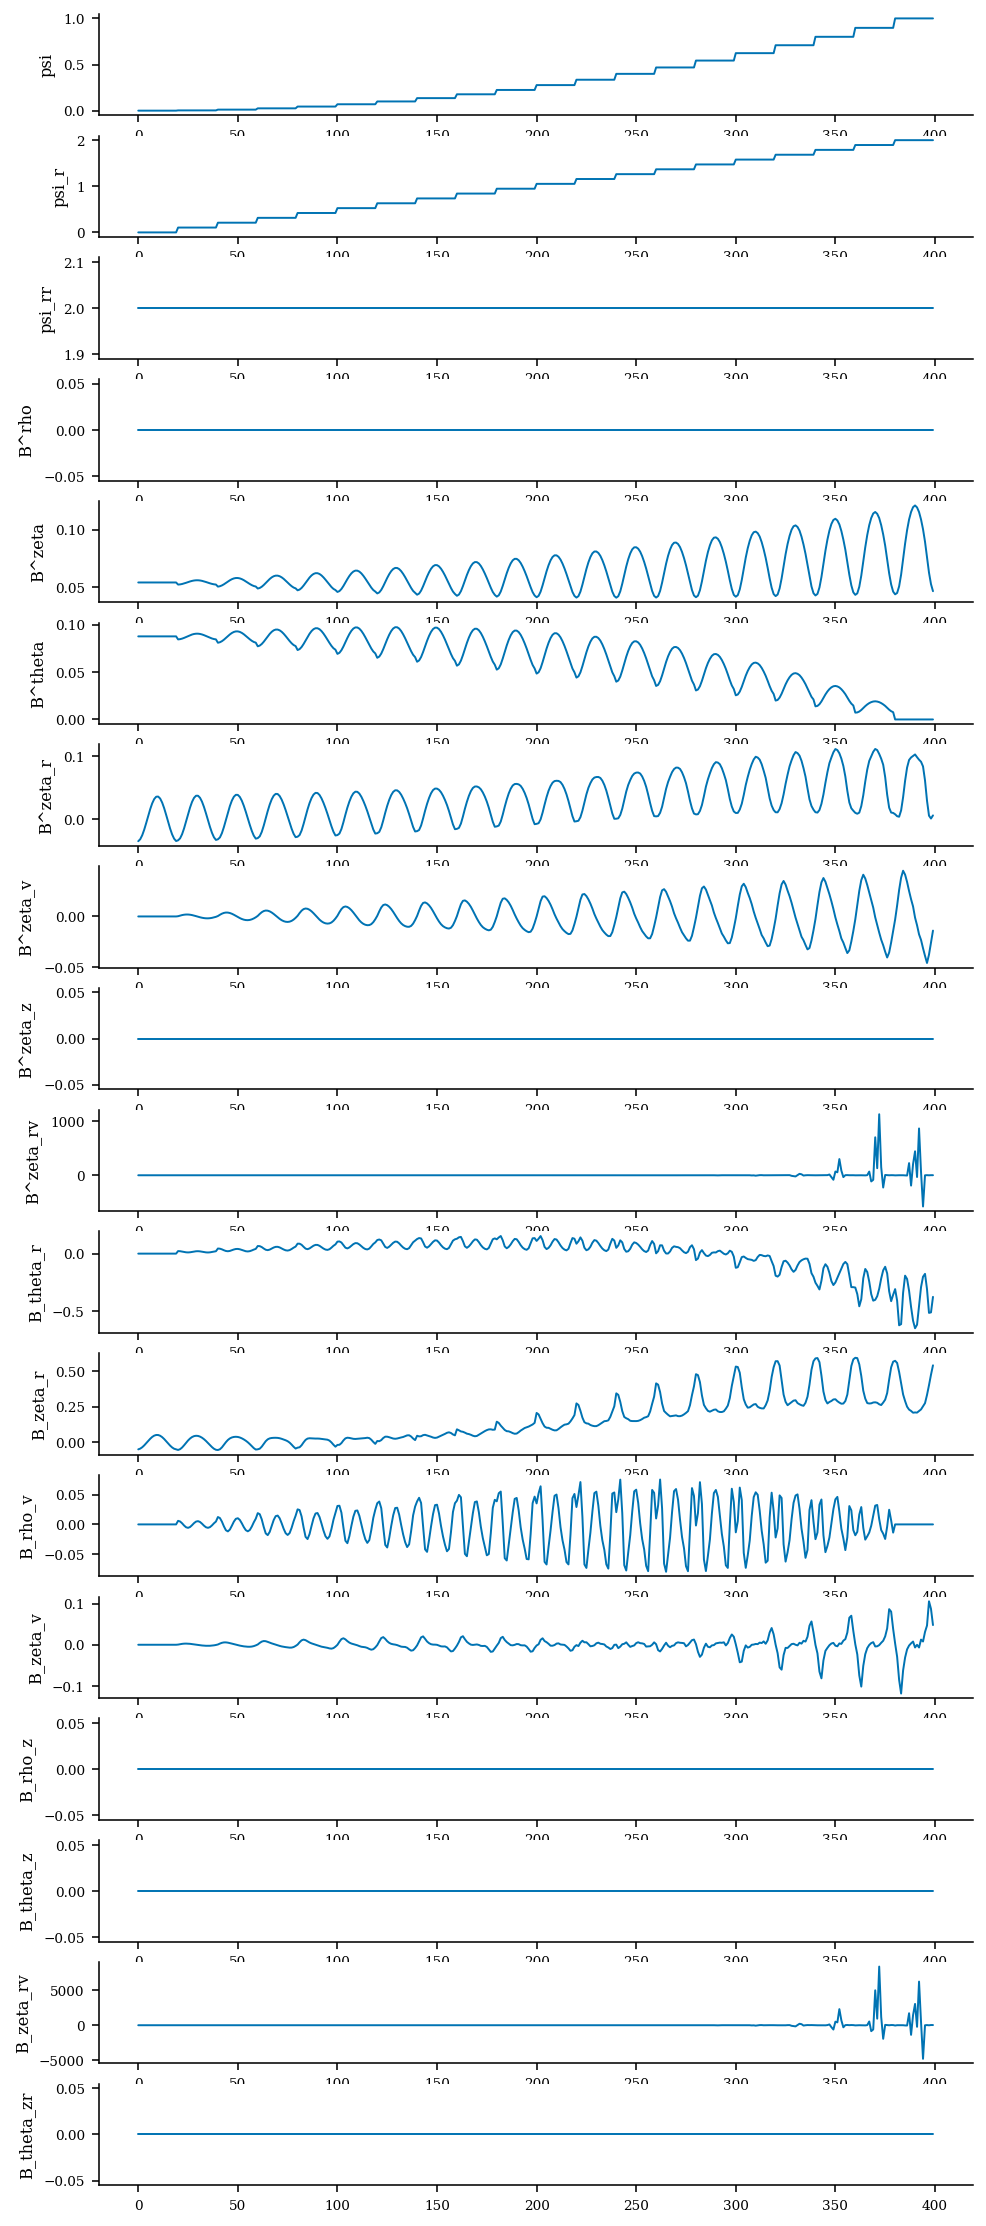

In [163]:
data = B_field
fig, ax = plt.subplots(len(data),figsize=(8,20))

for i,(key,val) in enumerate(data.items()):
    if val.ndim >1:
        val = val.T
    ax[i].plot(val,lw=1)
    ax[i].set_ylabel(key)
    if np.any(np.isnan(val)):
        print(key)

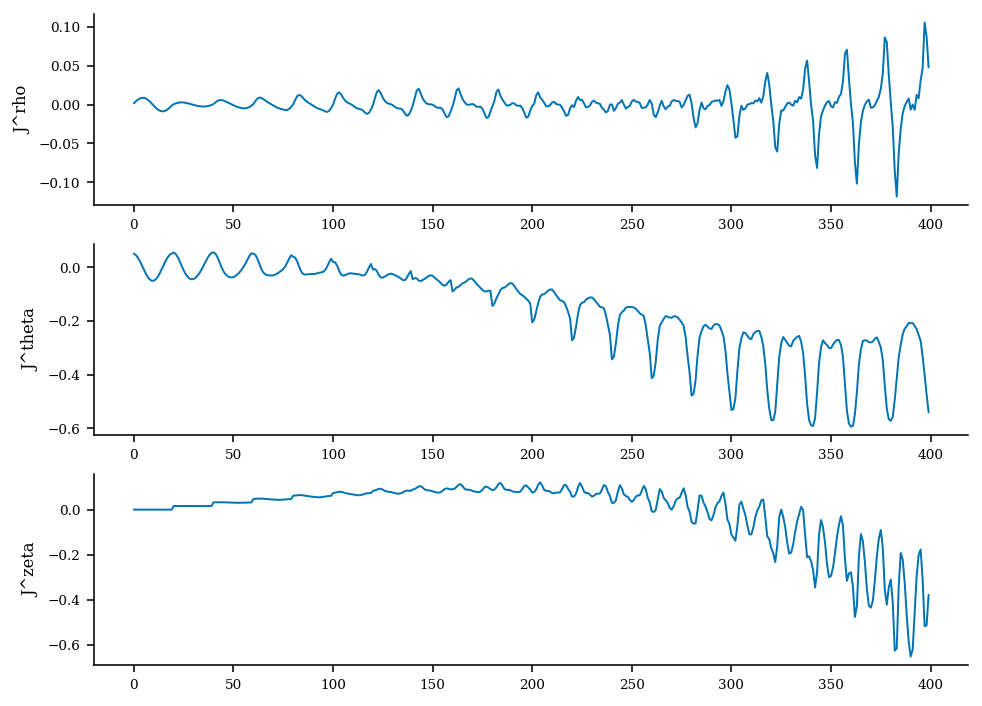

In [164]:
data = J_field
fig, ax = plt.subplots(len(data),figsize=(8,6))

for i,(key,val) in enumerate(data.items()):
    if val.ndim >1:
        val = val.T
    ax[i].plot(val,lw=1)
    ax[i].set_ylabel(key)
    if np.any(np.isnan(val)):
        print(key)

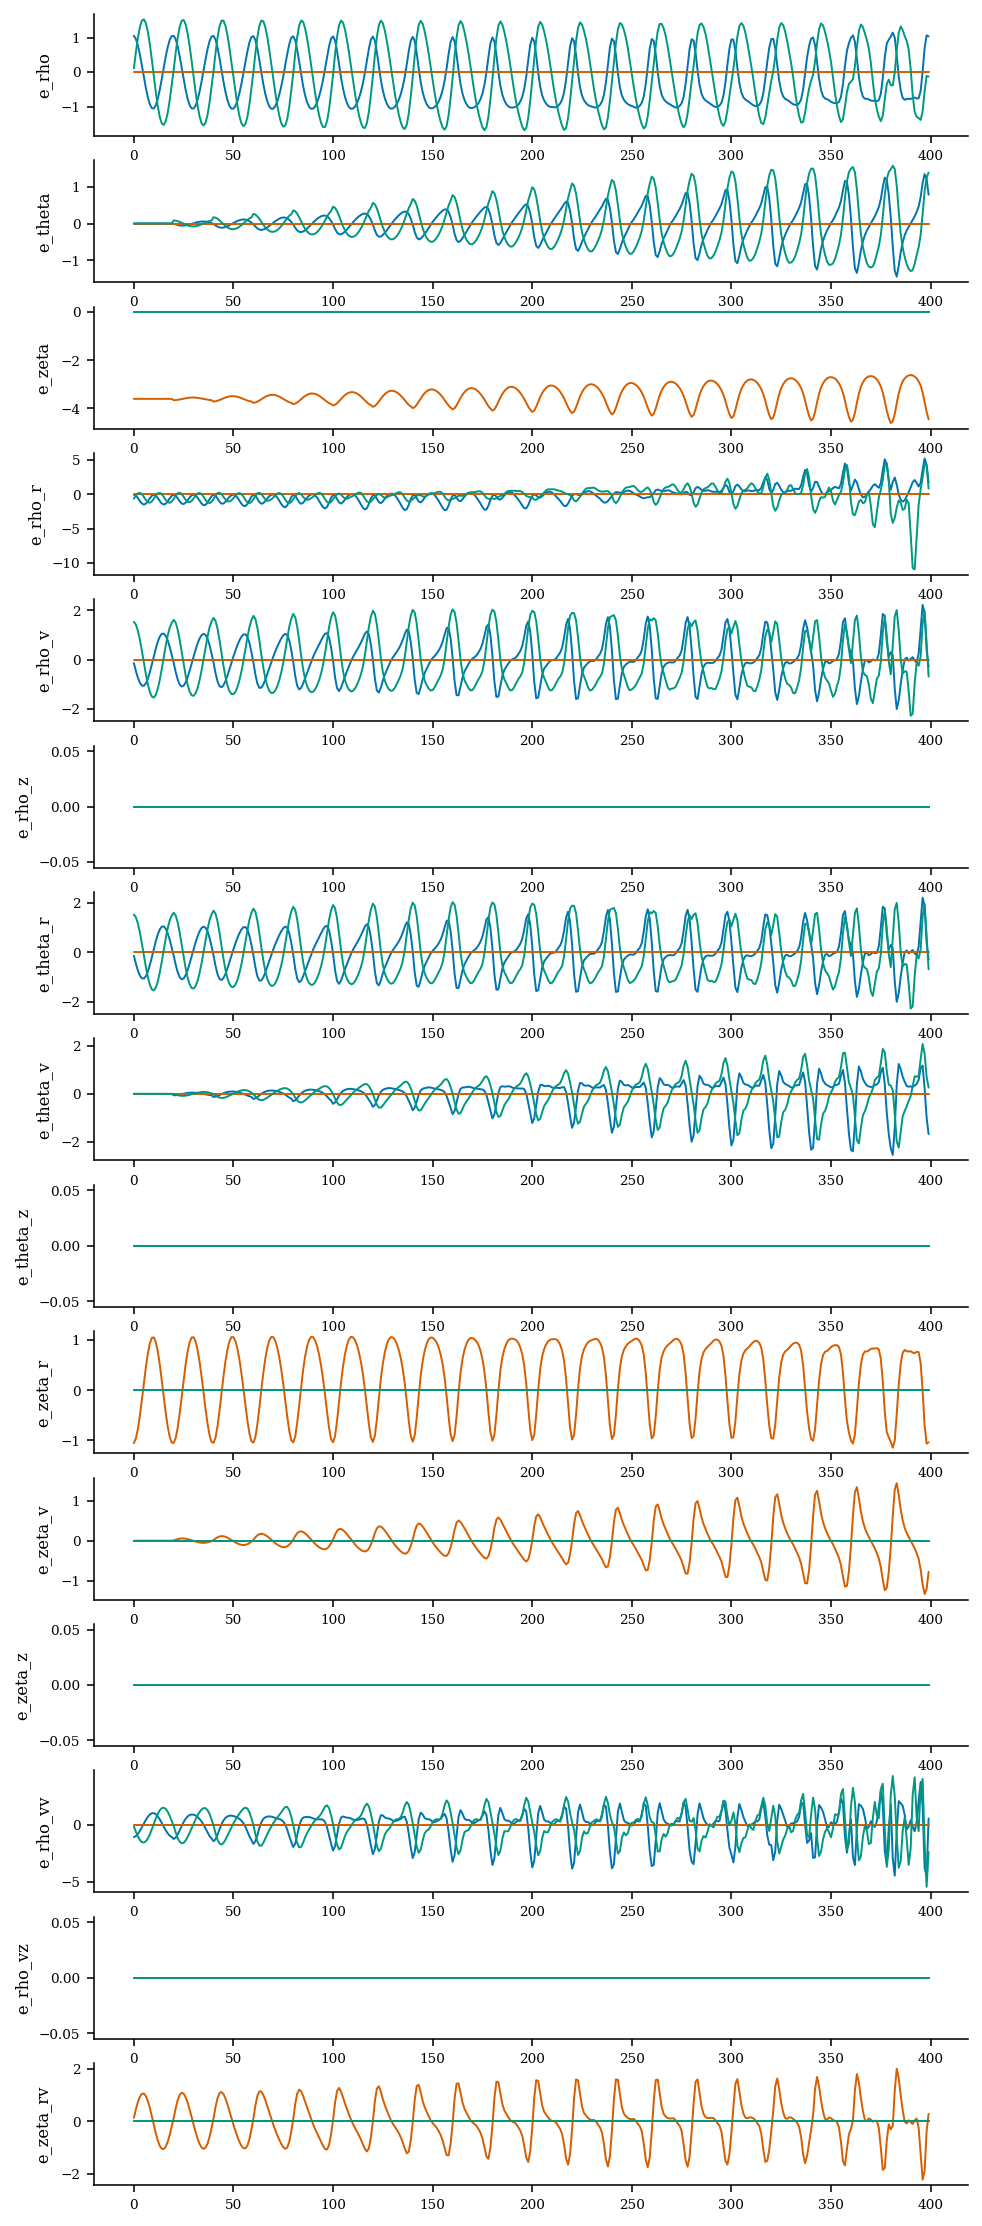

In [165]:
data = covariant_basis
fig, ax = plt.subplots(len(data),figsize=(8,20))

for i,(key,val) in enumerate(data.items()):
    if val.ndim >1:
        val = val.T
    ax[i].plot(val,lw=1)
    ax[i].set_ylabel(key)
    if np.any(np.isnan(val)):
        print(key)

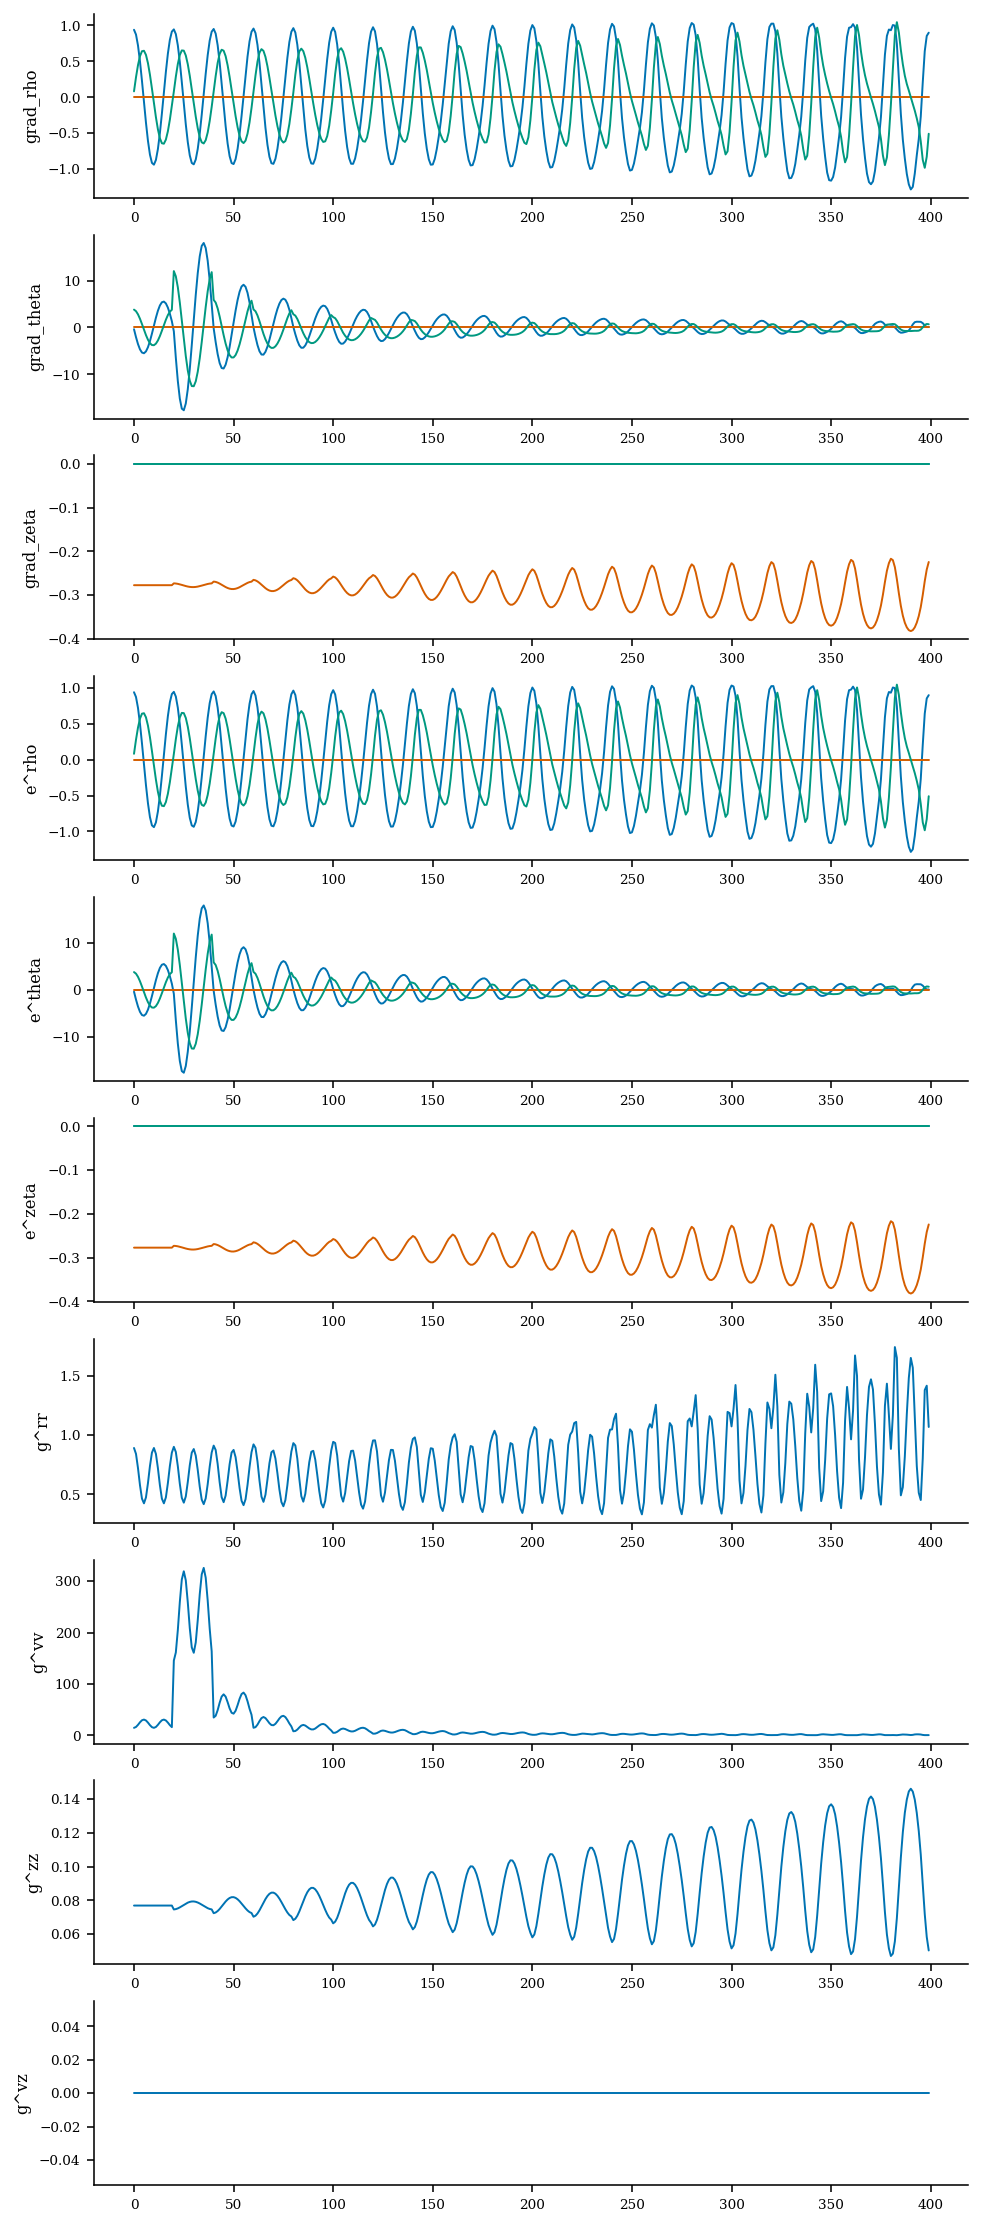

In [166]:
data = contravariant_basis
fig, ax = plt.subplots(len(data),figsize=(8,20))

for i,(key,val) in enumerate(data.items()):
    if val.ndim >1:
        val = val.T
    ax[i].plot(val,lw=1)
    ax[i].set_ylabel(key)
    if np.any(np.isnan(val)):
        print(key)

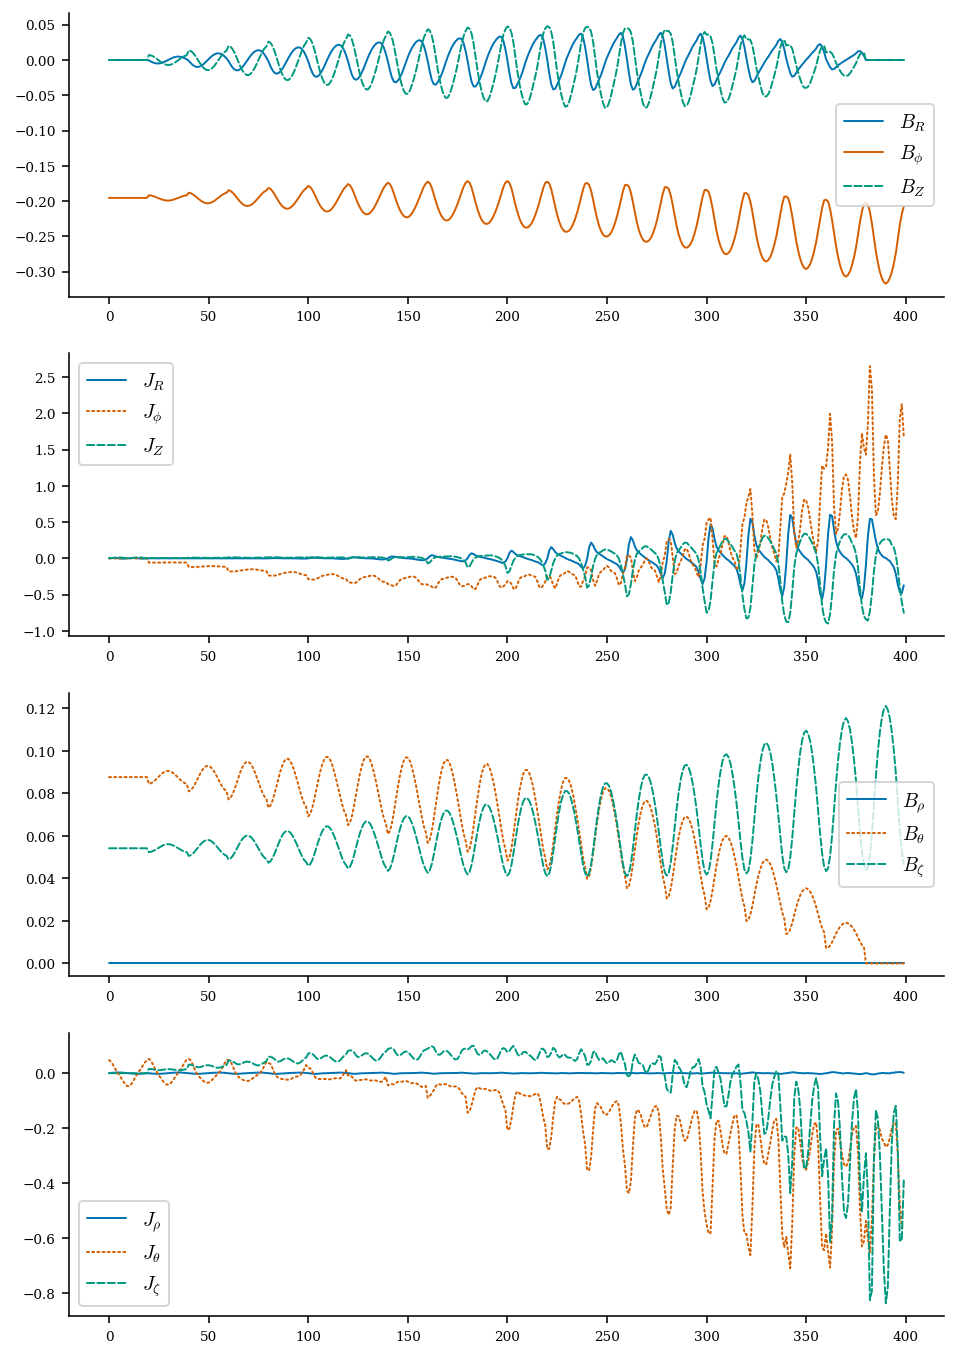

In [167]:
B = B_field['B^zeta']*covariant_basis['e_zeta'] + B_field['B^theta']*covariant_basis['e_theta'] \
    + B_field['B^rho']*covariant_basis['e_rho']
J = J_field['J^zeta']*covariant_basis['e_zeta'] + J_field['J^theta']*covariant_basis['e_theta'] \
    + J_field['J^rho']*covariant_basis['e_rho']

fig, ax = plt.subplots(4, figsize=(8,12))

ax[0].plot(B[0],lw=1,label='$B_R$')
ax[0].plot(B[1],lw=1,label='$B_\\phi$')
ax[0].plot(B[2],lw=1,ls='--',label='$B_Z$')
ax[0].legend()
ax[1].plot(J[0],lw=1,label='$J_R$')
ax[1].plot(J[1],lw=1,ls=':',label='$J_\\phi$')
ax[1].plot(J[2],lw=1,ls='--',label='$J_Z$')
ax[1].legend()
ax[2].plot(B_field['B^rho'],lw=1,label='$B_\\rho$')
ax[2].plot(B_field['B^theta'],lw=1,ls=':',label='$B_\\theta$')
ax[2].plot(B_field['B^zeta'],lw=1,ls='--',label='$B_\zeta$')
ax[2].legend()
ax[3].plot(J_field['J^rho']*helical,lw=1,label='$J_\\rho$')
ax[3].plot(J_field['J^theta']*radial,lw=1,ls=':',label='$J_\\theta$')
ax[3].plot(J_field['J^zeta']*radial,lw=1,ls='--',label='$J_\zeta$')
ax[3].legend()

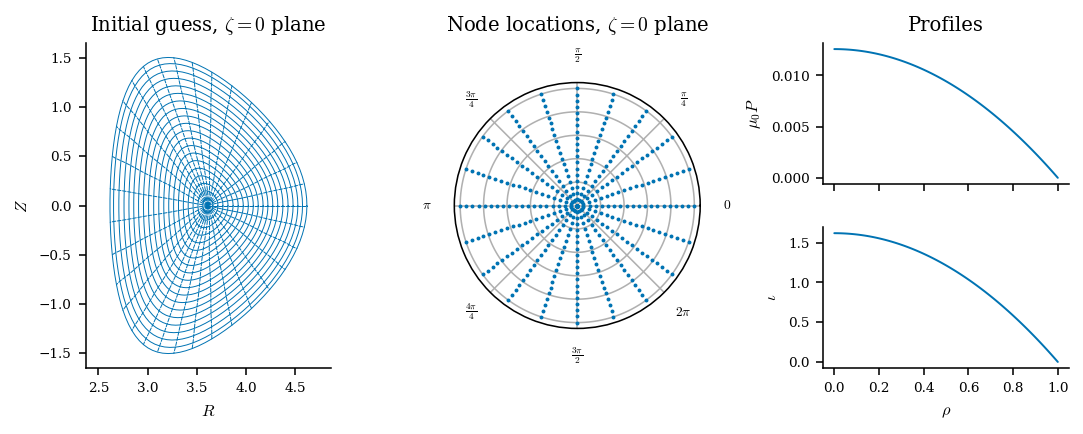

In [168]:
# Inputs
Psi_total = 1
M = 6
N = 0
NFP = 1
zern_idx = get_zern_basis_idx_dense(M,N)
lambda_idx = get_double_four_basis_idx_dense(M,N)

# profiles, polynomial basis
p0 = 1e4
pressfun_params = (p0,0,-p0)
iota0 = 1.618
iotafun_params = (iota0,0,-iota0)


# Node locations
r = np.linspace(0.,1,20)
dr = np.diff(r)[0]
v = np.linspace(0,2*jnp.pi,21)[:-1]
dv = np.diff(v)[0]
# z = np.linspace(0,2*np.pi/NFP,N*)
dz = 2*np.pi/NFP
rr,vv = np.meshgrid(r,v,indexing='ij')
rr = rr.flatten()
vv = vv.flatten()
zz = np.zeros_like(rr)
nodes = np.stack([rr,vv,zz])
dr = dr*np.ones_like(rr)
dv = dv*np.ones_like(vv)
dz = dz*np.ones_like(zz)
node_volume = np.stack([dr,dv,dz])
axn = np.where(rr == 0)[0]

# interpolator
derivatives = get_needed_derivatives('force')
zernt = ZernikeTransform(nodes,zern_idx,NFP,derivatives)


# Boundary Shape as fourier series
bdry_mode = 'spectral'
bdryM = jnp.arange(-M,M+1)
bdryN = jnp.arange(-N,N+1)
bdryM, bdryN = jnp.meshgrid(bdryM, bdryN, indexing='ij')
bdryM = bdryM.flatten()
bdryN = bdryN.flatten()
bdryR = jnp.zeros(len(bdryM),dtype=jnp.float64)
bdryZ = jnp.zeros(len(bdryM),dtype=jnp.float64)

# bndryR = [0.000; 0.00; 3.51; -1.00; 0.106];
bdryR = put(bdryR, jnp.where(jnp.logical_and(bdryM == 0, bdryN == 0))[0], 3.51)
bdryR = put(bdryR, jnp.where(jnp.logical_and(bdryM == 1, bdryN == 0))[0], -1.0)
bdryR = put(bdryR, jnp.where(jnp.logical_and(bdryM == 2, bdryN == 0))[0], 0.106)
#bndryZ = [0.160; 1.47; 0.00;  0.00; 0.000];
bdryZ = put(bdryZ, jnp.where(jnp.logical_and(bdryM == -2, bdryN == 0))[0], 0.160)
bdryZ = put(bdryZ, jnp.where(jnp.logical_and(bdryM == -1, bdryN == 0))[0], 1.47)

bdry_poloidal = bdryM
bdry_toroidal = bdryN

# # Boundary shape in real space
# bdry_mode = 'real'
# bdry_theta = np.linspace(0,2*np.pi,101)
# bdry_psi = np.zeros_like(bdry_theta)
# b = 1
# a = 1
# R0 = 2
# Z0 = 0
# bdryR = R0 + b*np.cos(bdry_theta)
# bdryZ = Z0 + a*np.sin(bdry_theta)
# bdry_poloidal = bdry_theta
# bdry_toroidal = bdry_psi





# initial guess
cR_init,cZ_init = get_initial_guess_scale_bdry(bdryR,bdryZ,bdry_poloidal,bdry_toroidal,zern_idx,NFP,mode=bdry_mode,nr=20,rcond=1e-6)
cL_init = np.zeros(len(lambda_idx))
x_init = np.concatenate([cR_init,cZ_init,cL_init])

# weights
weights = {'F':1e6,     # force balance error
           'R':1e4,     # error in R component of bdry
           'Z':1e4,     # error in Z component of bdry
           'L':1e4}     # error in sum lambda_mn


nodes = jnp.asarray(nodes)
node_volume = jnp.asarray(node_volume)

args = (zern_idx,lambda_idx,NFP,zernt,nodes,pressfun_params,iotafun_params,Psi_total,
        node_volume,bdryR,bdryZ,bdry_poloidal,bdry_toroidal,weights)


fig, ax = plot_IC(cR_init, cZ_init, zern_idx, NFP, nodes, pressfun_params, iotafun_params)


In [169]:
if bdry_mode == 'real':
    bdry_fun = compute_bc_err_RZ
elif bdry_mode == 'spectral':
    bdry_fun = compute_bc_err_four

@conditional_decorator(functools.partial(jit,static_argnums=np.arange(1,15)), use_jax)
def lstsq_obj(x,zern_idx,lambda_idx,NFP,zernt,nodes,pressfun_params,iotafun_params,
              Psi_total,node_volume,bdryR,bdryZ,bdry_poloidal,bdry_toroidal,weights):
    
    cR,cZ,cL = unpack_x(x,zern_idx)
    errF = compute_force_error_nodes(cR,cZ,zernt,nodes,pressfun_params,iotafun_params,Psi_total,node_volume)
    errR,errZ = bdry_fun(cR,cZ,cL,zern_idx,lambda_idx,bdryR,bdryZ,bdry_poloidal,bdry_toroidal,NFP)
    errL = compute_lambda_err(cL,lambda_idx,NFP)
    # divide through by size of the array so weighting isn't thrown off by more points
    loss = jnp.concatenate([weights['F']*errF.flatten()/errF.size,   
                           weights['R']*errR.flatten()/errR.size,
                           weights['Z']*errZ.flatten()/errZ.size,
                           weights['L']*errL.flatten()/errL.size])
    return loss

@conditional_decorator(functools.partial(jit,static_argnums=np.arange(1,15)), use_jax)
def force_obj(x,zern_idx,lambda_idx,NFP,zernt,nodes,pressfun_params,iotafun_params,
              Psi_total,node_volume,bdryR,bdryZ,bdry_poloidal,bdry_toroidal,weights):

    cR,cZ,cL = unpack_x(x,zern_idx)
    errF = compute_force_error_nodes(cR,cZ,zernt,nodes,pressfun_params,iotafun_params,Psi_total,node_volume)
    return rms(errF)

@conditional_decorator(functools.partial(jit,static_argnums=np.arange(1,15)), use_jax)
def bc_constraint_fun(x,zern_idx,lambda_idx,NFP,zernt,nodes,pressfun_params,iotafun_params,
                      Psi_total,node_volume,bdryR,bdryZ,bdry_poloidal,bdry_toroidal,weights):

    cR,cZ,cL = unpack_x(x,zern_idx)
    errR,errZ = bdry_fun(cR,cZ,cL,zern_idx,lambda_idx,bdryR,bdryZ,bdry_poloidal,bdry_toroidal,NFP)
    err = jnp.concatenate([errR,errZ])
    return jnp.array([rms(errR), rms(errZ)])

@conditional_decorator(functools.partial(jit,static_argnums=np.arange(1,15)), use_jax)
def lambda_constraint_fun(x,zern_idx,lambda_idx,NFP,zernt,nodes,pressfun_params,iotafun_params,
                          Psi_total,node_volume,bdryR,bdryZ,bdry_poloidal,bdry_toroidal,weights):

    cR,cZ,cL = unpack_x(x,zern_idx)
    errL = compute_lambda_err(cL,lambda_idx,NFP)

    return errL

class FiniteDifferenceJacobian():
    def __init__(self, fun, rel_step=jnp.finfo(jnp.float64).eps**(1/3)):
        self.fun = fun
        self.rel_step = rel_step
    @conditional_decorator(functools.partial(jit,static_argnums=np.arange(0,2)), use_jax)
    def __call__(self,x0,*args):
        f0 = self.fun(x0,*args)
        m = f0.size
        n = x0.size
        J_transposed = jnp.empty((n, m))
        idx = jnp.arange(m).astype(jnp.int64)
        sign_x0 = (x0 >= 0).astype(float) * 2 - 1
        h = self.rel_step * sign_x0 * jnp.maximum(1.0, jnp.abs(x0))
        h_vecs = jnp.diag(h)
        for i in range(h.size):
            x1 = x0 - h_vecs[i]
            x2 = x0 + h_vecs[i]
            dx = x2[i] - x1[i]
            f1 = self.fun(x1,*args)
            f2 = self.fun(x2,*args)
            df = f2 - f1
            dfdx = df / dx
            put(J_transposed,i*m+idx,dfdx)
        if m == 1:
            J_transposed = jnp.ravel(J_transposed)
        return J_transposed.T
    
def callback(x,zern_idx,lambda_idx,NFP,zernt,nodes,pressfun_params,iotafun_params,
             Psi_total,node_volume,bdryR,bdryZ,bdry_poloidal,bdry_toroidal,weights):
    
    cR,cZ,cL = unpack_x(x,zern_idx)
    errF = compute_force_error_nodes(cR,cZ,zernt,nodes,pressfun_params,iotafun_params,Psi_total,node_volume)
    errR,errZ = bdry_fun(cR,cZ,cL,zern_idx,lambda_idx,bdryR,bdryZ,bdry_poloidal,bdry_toroidal,NFP)
    errL = compute_lambda_err(cL,lambda_idx,NFP)

    errFrms = rms(errF)
    errRrms = rms(errR)
    errZrms = rms(errZ)    
    errLrms = rms(errL)
    
    loss = np.concatenate([weights['F']*errF.flatten(),
                           weights['R']*errR.flatten(),
                           weights['Z']*errZ.flatten(),
                           weights['L']*errL.flatten()])
    lossrms = rms(loss)    
    print('Weighted Loss: {:10.3e}  errF: {:10.3e}  errBdryR: {:10.3e}  errBdryZ: {:10.3e}  errLambda: {:10.3e}'.format(
    lossrms,errFrms,errRrms,errZrms,errLrms))

In [170]:
lstsq_obj = jit(lstsq_obj, static_argnums=np.arange(len(args))+1)
jac = jit(jax.jacfwd(lstsq_obj),static_argnums=np.arange(len(args))+1)

In [171]:
callback(x_init,*args)

Weighted Loss:  3.095e+04  errF:  3.146e-02  errBdryR:  2.196e-04  errBdryZ:  3.238e-04  errLambda:  0.000e+00


/home/fouriest/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


In [47]:
%%timeit
cost = lstsq_obj(x_init,*args).block_until_ready() 

1.75 ms ± 132 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [271]:
%%timeit
foo = jac(x_init,*args).block_until_ready() 

32 ms ± 961 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [39]:
x1 = x_init #+ .001*np.random.normal(size=x_init.size)
callback(x1)
out = scipy.optimize.least_squares(lstsq_obj,
                                   x1,
                                   args=args,
                                   jac=jac if use_jax else None,
                                   x_scale='jac',
                                   ftol=1e-10, 
                                   xtol=1e-8, 
                                   gtol=1e-8, 
                                   max_nfev=1000, 
                                   verbose=2)
x = out['x']

Loss:  3.095e+04  errF:  3.146e-02  errR:  2.196e-04  errZ:  3.238e-04  errL:  0.000e+00
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         6.1870e+05                                    4.83e+08    
       1              3         4.1576e+04      5.77e+05       2.64e-01       4.46e+07    
       2              4         8.3059e+03      3.33e+04       1.58e-01       2.92e+07    
       3              5         8.1860e+02      7.49e+03       1.07e-01       5.44e+06    
       4              7         2.8088e+02      5.38e+02       9.78e-02       2.66e+06    
       5              9         6.9773e+01      2.11e+02       2.04e-02       5.72e+05    
       6             11         6.5503e+01      4.27e+00       1.03e-02       4.48e+04    
       7             13         6.4713e+01      7.90e-01       5.28e-03       1.36e+04    
       8             14         6.3739e+01      9.74e-01       1.08e-02       4.84e+04    
 

In [65]:
print('Initial')
callback(x_init, *args)
print('Final')
callback(x, *args)

Initial
Weighted Loss:  3.095e+04  errF:  3.146e-02  errBdryR:  2.196e-04  errBdryZ:  3.238e-04  errLambda:  0.000e+00
Final
Weighted Loss:  2.955e+02  errF:  3.004e-04  errBdryR:  1.224e-04  errBdryZ:  1.029e-04  errLambda:  3.744e-08


In [89]:
R0, Z0 = axis_posn(cR,cZ,zern_idx,NFP)
'{:10.3e} {:10.3e}'.format(R0,Z0)

' 3.605e+00  6.185e-02'

(array([3.60542809]), array([0.06185332]))


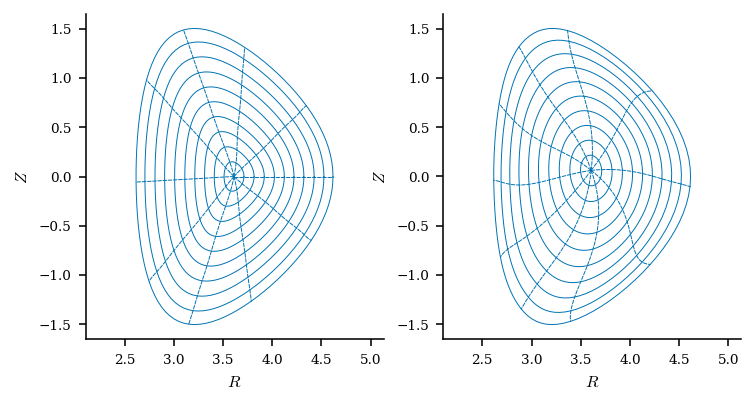

In [41]:
x = out['x']
cR,cZ,cL = unpack_x(x,zern_idx)
print(axis_posn(cR,cZ,zern_idx,NFP))

fig, ax = plt.subplots(1,2,figsize=(6,3))
plot_coord_surfaces(cR_init,cZ_init,zern_idx,NFP,nr=10,ntheta=10,ax=ax[0])
plot_coord_surfaces(cR,cZ,zern_idx,NFP,nr=10,ntheta=10,ax=ax[1])

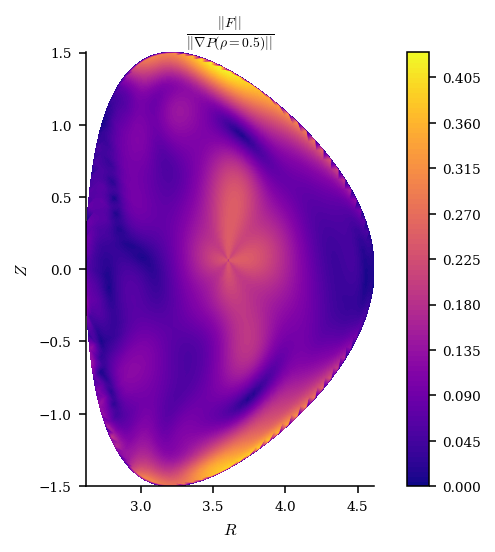

In [83]:
fig, ax = plt.subplots()
ax, im = plot_fb_err(cR,cZ,cL,zern_idx,lambda_idx,NFP,iotafun_params, pressfun_params, Psi_total,
                domain='real', normalize='global', ax=ax, log=False, cmap='plasma')
plt.colorbar(im)

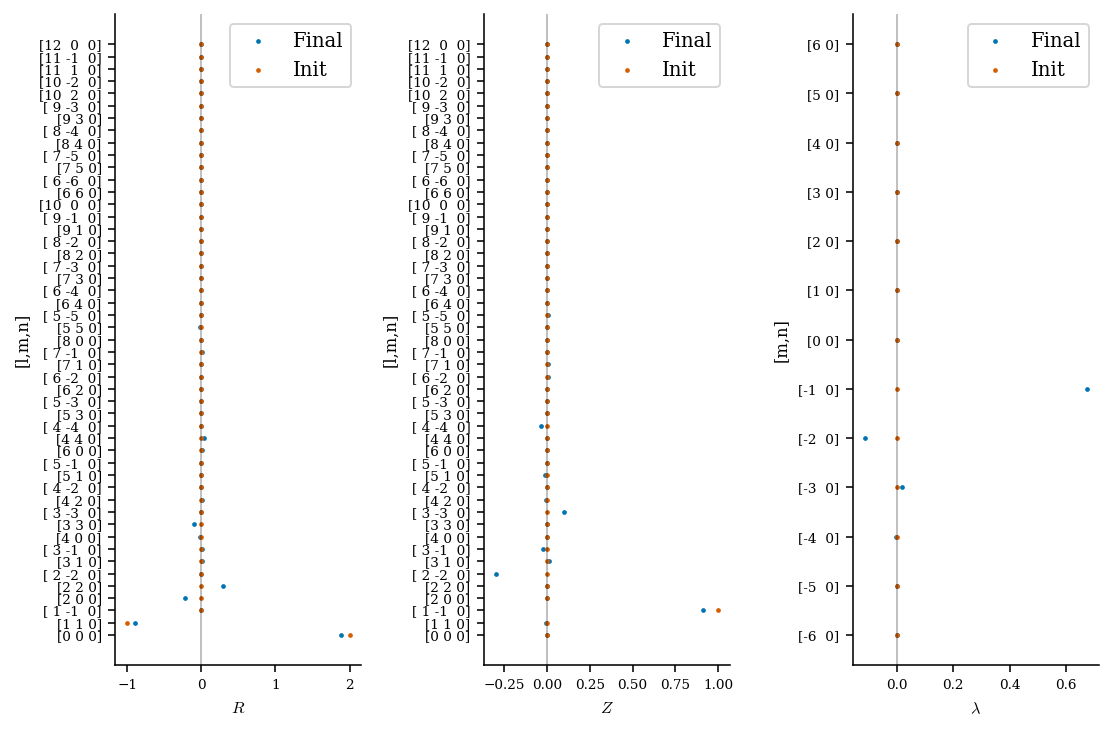

In [223]:
plot_coeffs(cR,cZ,cL,zern_idx,lambda_idx,cR_init,cZ_init,cL_init);

In [58]:
force_obj = jit(force_obj, static_argnums=np.arange(1,15))
force_jac = jit(jax.jacfwd(force_obj),static_argnums=np.arange(1,15))
bc_constraint_fun = jit(bc_constraint_fun, static_argnums=np.arange(1,15))
bc_jac = jit(jax.jacfwd(bc_constraint_fun),static_argnums=np.arange(1,15))

force_obj(x_init,*args).block_until_ready();
force_jac(x_init,*args).block_until_ready();
bc_constraint_fun(x_init,*args).block_until_ready();
bc_jac(x_init,*args).block_until_ready();

In [59]:
callback(x_init)

# slsqp_constraints=[{'type':'eq',
#                     'fun':lambda_constraint_fun,
#                     'jac':lambda_jac if use_jax else None,
#                     'args': args},
#                    {'type':'eq',
#                     'fun':bc_constraint_fun,
#                     'jac':bc_jac if use_jax else None,
#                     'args': args}]

trf_constraints = [scipy.optimize.NonlinearConstraint(lambda x: bc_constraint_fun(x,*args), 
                                                      -1e-3, 
                                                      1e-3, 
                                                      jac=lambda x: bc_jac(x,*args), 
                                                      keep_feasible=False, 
                                                      ),
                   scipy.optimize.LinearConstraint(get_lambda_constraint_matrix(M,N,NFP), 0, 0)
                  ]

# out = scipy.optimize.minimize(force_obj,
#                               x_init,
#                               args=args,
#                               method='SLSQP',
#                               jac=force_jac if use_jax else None,
#                               options={'disp':True,
#                                        'maxiter':500},
#                               constraints=slsqp_constraints,
#                               callback=callback
#                              )

out = scipy.optimize.minimize(force_obj,
                              x_init,
                              args=args,
                              method='trust-constr',
                              jac=force_jac if use_jax else None,
                              options={'disp':True,
                                       'maxiter':5000},
                              constraints=trf_constraints,
#                               callback=callback
                             )

Loss:  2.228e+04  errF:  2.731e-02  errR:  4.026e-07  errZ:  6.097e-16  errL:  0.000e+00
The maximum number of function evaluations is exceeded.
Number of iterations: 5001, function evaluations: 5001, CG iterations: 5197, optimality: 2.50e-01, constraint violation: 1.05e-07, execution time: 7.9e+01 s.


In [60]:
callback(x_init)
callback(out['x'])

Loss:  2.228e+04  errF:  2.731e-02  errR:  4.026e-07  errZ:  6.097e-16  errL:  0.000e+00
Loss:  1.259e+04  errF:  1.544e-02  errR:  2.934e-06  errZ:  2.339e-06  errL:  1.052e-07


In [90]:
def DESC_to_gfile(cR,cZ,iotafun_params,pressfun_params,Psi_total,M,N,NFP,nw=65,nh=65,nr=50,ntheta=50,npsi=1000, 
                  rdim=None,zdim=None,rleft=None,rcentr=None,zmid=None,axis_flux=0):

    g = {}
    g['date']=pytime.localtime()
    g['shot']=0
    g['time']=0
    g['efit']='DESC'
    g['nw']=nw
    g['nh']=nh


    # get poloidal flux (psi) as function of toroidal flux (rho)
    efitPsi = np.linspace(0,1,g['nw'])
    rho_n = np.linspace(1e-3,1,npsi)
    rho = 2*Psi_total*rho_n
    iota = iotafun(rho_n)
    psi = scipy.integrate.cumtrapz(rho*iota,rho_n,initial=axis_flux)
    psi_n = (psi - np.min(psi))/(np.max(psi)-np.min(psi))
    psi_n_of_rho_n = scipy.interpolate.CubicSpline(rho_n,psi_n)
    psi_of_rho_n = scipy.interpolate.CubicSpline(rho_n,psi)
    rho_n_of_psi_n = scipy.interpolate.CubicSpline(psi_n,rho_n)

    # get Bt
    vv = np.zeros_like(rho_n)
    zz = np.zeros_like(rho_n)
    nodes = np.stack([rho_n,vv,zz])
    axn = np.where(nodes[0]==0)[0]
    zernt = ZernikeTransform(nodes,M,N,NFP)
    coordinate_derivatives = compute_coordinate_derivatives(cR,cZ,zernt)
    covariant_basis = compute_covariant_basis(coordinate_derivatives)
    jacobian = compute_jacobian(coordinate_derivatives,covariant_basis)
    B_field = compute_B_field(Psi_total, jacobian, nodes, axn, covariant_basis, iotafun_params)
    R = zernt.transform(cR,0,0,0).flatten()
    B = B_field['B^theta']*covariant_basis['e_theta'] + B_field['B^zeta']*covariant_basis['e_zeta']
    Bt = B[1]
    g['bcentr'] = np.linalg.norm(B[:,0])

    # compute profiles
    Fpol = scipy.interpolate.CubicSpline(rho_n,R*Bt)
    g['fpol'] = Fpol(rho_n_of_psi_n(efitPsi))
    g['ffprime'] = Fpol(rho_n_of_psi_n(efitPsi))*Fpol(rho_n_of_psi_n(efitPsi),nu=1)*rho_n_of_psi_n(efitPsi,nu=1)
    g['pres'] = pressfun(rho_n_of_psi_n(efitPsi))
    g['pprime'] = pressfun(rho_n_of_psi_n(efitPsi),nu=1)*rho_n_of_psi_n(efitPsi,nu=1)
    iotapsi = iotafun(rho_n_of_psi_n(efitPsi))
    qidx = np.where(iotapsi != 0)[0]
    g['qpsi'] = scipy.interpolate.CubicSpline(efitPsi[qidx],1/iotapsi[qidx])(efitPsi)


    # compute psi(R,Z)
    r = np.linspace(0,1,nr)
    v = np.linspace(0,2*np.pi,ntheta)
    rr,vv = np.meshgrid(r,v,indexing='ij')
    rr = rr.flatten()
    vv = vv.flatten()
    zz = np.zeros_like(rr)
    nodes = np.stack([rr,vv,zz])
    axn = np.where(rr==0)[0]
    bdryn = np.where(rr==1)[0]
    zernt = ZernikeTransform(nodes,M,N,NFP)

    R = zernt.transform(cR,0,0,0).flatten()
    Z = zernt.transform(cZ,0,0,0).flatten()
    psiRZ = psi_of_rho_n(rr)

    g['rmaxis'] = np.mean(R[axn])
    g['zmaxis'] = np.mean(Z[axn])
    g['nbbbs'] = bdryn.size
    g['rbbbs'] = R[bdryn]
    g['zbbbs'] = Z[bdryn]
    g['axis_flux'] = np.mean(psiRZ[axn])
    g['boundary_flux'] = np.mean(psiRZ[bdryn])

    g['rdim'] = rdim if rdim else (np.max(R)-np.min(R))*1.5
    g['rcentr'] = rcentr if rcentr else (np.max(R)+np.min(R))/2
    g['zdim'] = zdim if zdim else (np.max(Z)-np.min(Z))*1.5
    g['zmid'] = zmid if zmid else (np.max(Z)+np.min(Z))/2
    g['rleft'] = rleft if rleft else g['rcentr'] - g['rdim']/2

    efitR = np.linspace(g['rleft'],g['rleft']+g['rdim'],g['nw'])
    efitZ = np.linspace(-g['zdim']/2,g['zdim']/2,g['nh'])
    efitRR,efitZZ = np.meshgrid(efitR,efitZ,indexing='ij')

    g['psirz'] = scipy.interpolate.griddata((R,Z),psiRZ,(efitRR,efitZZ),method='cubic').T
    g['psirz'][np.isnan(g['psirz'])] = g['boundary_flux']

    g['limitr'] = 0
    g['rlimitr'] = np.array([])
    g['zlimitr'] = np.array([])
    
    return g

In [91]:
plot_gfile(DESC_to_gfile(cR,cZ,iotafun,pressfun,Psi_total,M,N,NFP))

TypeError: iotafun() missing 2 required positional arguments: 'nu' and 'params'

In [ ]:
Rfoo = ['R','R_r','R_v','R_z','R_rr','R_rv','R_vv','R_zr','R_zv','R_zz','R_rrv','R_rvv','R_zrv','R_rrvv'];
Rfoo = ['Z','Z_r','Z_v','Z_z','Z_rr','Z_rv','Z_vv','Z_zr','Z_zv','Z_zz','Z_rrv','Z_rvv','Z_zrv','Z_rrvv'];


fig, ax = plt.subplots(len(Rfoo), figsize=(6,12))
for i, foo in enumerate(Rfoo):
    ax[i].plot(coordinate_derivatives[foo],lw=1)
    ax[i].set_ylabel(foo)

In [ ]:
from matplotlib.ticker import FormatStrFormatter
fig, ax = plt.subplots(1,3, figsize=(8,2))

im0 = ax[0].tricontourf(nodes[0],nodes[1],F_err[0], levels=30)
ax[0].set_title('$F_R$')
ax[0].set_xlabel('$\\rho$')
ax[0].set_ylabel('$\\vartheta$')
# ax[0].set_xticks(np.linspace(0,1e-3,3))
# ax[0].xaxis.set_major_formatter(FormatStrFormatter('%.2e'))
ax[0].set_yticks([0,1/3*np.pi, 2/3*np.pi, 3/3*np.pi,4/3*np.pi, 5/3*np.pi, 6/3*np.pi])
ax[0].set_yticklabels(['0','$\\frac{1\\pi}{3}$','$\\frac{2\\pi}{3}$','$\\pi$','$\\frac{4\\pi}{3}$','$\\frac{5\\pi}{3}$','$2\\pi$'])
fig.colorbar(im0, ax=ax[0], orientation='vertical',fraction=.1)

im1 = ax[1].tricontourf(nodes[0],nodes[1],F_err[1], levels=30)
ax[1].set_title('$F_\\phi$')
ax[1].set_xlabel('$\\rho$')
ax[1].set_ylabel('$\\vartheta$')
# ax[1].set_xticks(np.linspace(0,1e-3,3))
# ax[1].xaxis.set_major_formatter(FormatStrFormatter('%.2e'))
ax[1].set_yticks([0,1/3*np.pi, 2/3*np.pi, 3/3*np.pi,4/3*np.pi, 5/3*np.pi, 6/3*np.pi])
ax[1].set_yticklabels(['0','$\\frac{1\\pi}{3}$','$\\frac{2\\pi}{3}$','$\\pi$','$\\frac{4\\pi}{3}$','$\\frac{5\\pi}{3}$','$2\\pi$'])
fig.colorbar(im1, ax=ax[1], orientation='vertical',fraction=.1)

im2 = ax[2].tricontourf(nodes[0],nodes[1],F_err[2], levels=30)
ax[2].set_title('$F_Z$')
ax[2].set_xlabel('$\\rho$')
ax[2].set_ylabel('$\\vartheta$')
# ax[2].set_xticks(np.linspace(0,1e-3,3))
# ax[2].xaxis.set_major_formatter(FormatStrFormatter('%.2e'))
ax[2].set_yticks([0,1/3*np.pi, 2/3*np.pi, 3/3*np.pi,4/3*np.pi, 5/3*np.pi, 6/3*np.pi])
ax[2].set_yticklabels(['0','$\\frac{1\\pi}{3}$','$\\frac{2\\pi}{3}$','$\\pi$','$\\frac{4\\pi}{3}$','$\\frac{5\\pi}{3}$','$2\\pi$'])
fig.colorbar(im2, ax=ax[2], orientation='vertical',fraction=.1)
# plt.axis('equal')
# plt.colorbar()
plt.subplots_adjust(wspace=.5)

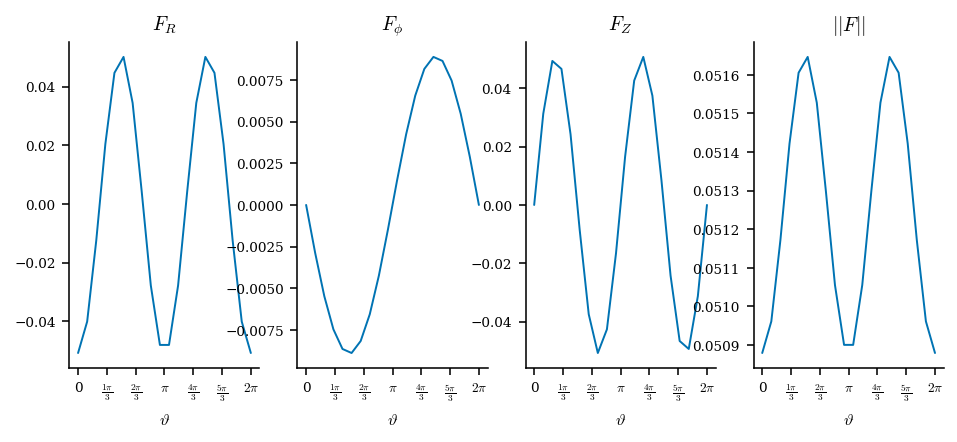

In [133]:
axn = np.where(nodes[0]==0)[0]
fig, ax = plt.subplots(1,4, figsize=(8,3))

ax[0].plot(nodes[1,axn],F_err[0,axn],lw=1)
ax[0].set_title('$F_R$')
ax[0].set_xlabel('$\\vartheta$')
ax[0].set_xticks([0,1/3*np.pi, 2/3*np.pi, 3/3*np.pi,4/3*np.pi, 5/3*np.pi, 6/3*np.pi])
ax[0].set_xticklabels(['0','$\\frac{1\\pi}{3}$','$\\frac{2\\pi}{3}$','$\\pi$','$\\frac{4\\pi}{3}$','$\\frac{5\\pi}{3}$','$2\\pi$'])

ax[1].plot(nodes[1,axn],F_err[1,axn],lw=1)
ax[1].set_title('$F_\\phi$')
ax[1].set_xlabel('$\\vartheta$')
ax[1].set_xticks([0,1/3*np.pi, 2/3*np.pi, 3/3*np.pi,4/3*np.pi, 5/3*np.pi, 6/3*np.pi])
ax[1].set_xticklabels(['0','$\\frac{1\\pi}{3}$','$\\frac{2\\pi}{3}$','$\\pi$','$\\frac{4\\pi}{3}$','$\\frac{5\\pi}{3}$','$2\\pi$'])

ax[2].plot(nodes[1,axn],F_err[2,axn],lw=1)
ax[2].set_title('$F_Z$')
ax[2].set_xlabel('$\\vartheta$')
ax[2].set_xticks([0,1/3*np.pi, 2/3*np.pi, 3/3*np.pi,4/3*np.pi, 5/3*np.pi, 6/3*np.pi])
ax[2].set_xticklabels(['0','$\\frac{1\\pi}{3}$','$\\frac{2\\pi}{3}$','$\\pi$','$\\frac{4\\pi}{3}$','$\\frac{5\\pi}{3}$','$2\\pi$'])

ax[3].plot(nodes[1,axn],np.linalg.norm(F_err[:,axn],axis=0),lw=1)
ax[3].set_title('$||F||$')
ax[3].set_xlabel('$\\vartheta$')
ax[3].set_xticks([0,1/3*np.pi, 2/3*np.pi, 3/3*np.pi,4/3*np.pi, 5/3*np.pi, 6/3*np.pi])
ax[3].set_xticklabels(['0','$\\frac{1\\pi}{3}$','$\\frac{2\\pi}{3}$','$\\pi$','$\\frac{4\\pi}{3}$','$\\frac{5\\pi}{3}$','$2\\pi$']);


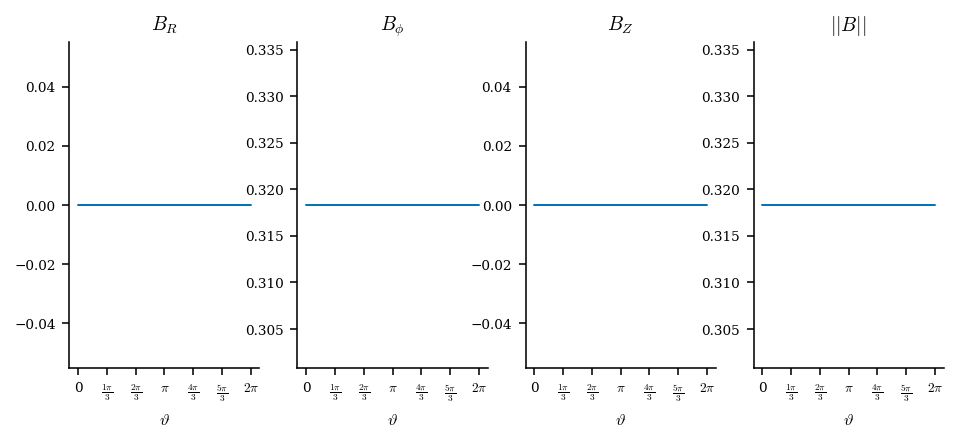

In [135]:
axn = np.where(nodes[0]==0)[0]
fig, ax = plt.subplots(1,4, figsize=(8,3))

ax[0].plot(nodes[1,axn],B[0,axn],lw=1)
ax[0].set_title('$B_R$')
ax[0].set_xlabel('$\\vartheta$')
ax[0].set_xticks([0,1/3*np.pi, 2/3*np.pi, 3/3*np.pi,4/3*np.pi, 5/3*np.pi, 6/3*np.pi])
ax[0].set_xticklabels(['0','$\\frac{1\\pi}{3}$','$\\frac{2\\pi}{3}$','$\\pi$','$\\frac{4\\pi}{3}$','$\\frac{5\\pi}{3}$','$2\\pi$'])

ax[1].plot(nodes[1,axn],B[1,axn],lw=1)
ax[1].set_title('$B_\\phi$')
ax[1].set_xlabel('$\\vartheta$')
ax[1].set_xticks([0,1/3*np.pi, 2/3*np.pi, 3/3*np.pi,4/3*np.pi, 5/3*np.pi, 6/3*np.pi])
ax[1].set_xticklabels(['0','$\\frac{1\\pi}{3}$','$\\frac{2\\pi}{3}$','$\\pi$','$\\frac{4\\pi}{3}$','$\\frac{5\\pi}{3}$','$2\\pi$'])

ax[2].plot(nodes[1,axn],B[2,axn],lw=1)
ax[2].set_title('$B_Z$')
ax[2].set_xlabel('$\\vartheta$')
ax[2].set_xticks([0,1/3*np.pi, 2/3*np.pi, 3/3*np.pi,4/3*np.pi, 5/3*np.pi, 6/3*np.pi])
ax[2].set_xticklabels(['0','$\\frac{1\\pi}{3}$','$\\frac{2\\pi}{3}$','$\\pi$','$\\frac{4\\pi}{3}$','$\\frac{5\\pi}{3}$','$2\\pi$'])

ax[3].plot(nodes[1,axn],np.linalg.norm(B[:,axn],axis=0),lw=1)
ax[3].set_title('$||B||$')
ax[3].set_xlabel('$\\vartheta$')
ax[3].set_xticks([0,1/3*np.pi, 2/3*np.pi, 3/3*np.pi,4/3*np.pi, 5/3*np.pi, 6/3*np.pi])
ax[3].set_xticklabels(['0','$\\frac{1\\pi}{3}$','$\\frac{2\\pi}{3}$','$\\pi$','$\\frac{4\\pi}{3}$','$\\frac{5\\pi}{3}$','$2\\pi$']);


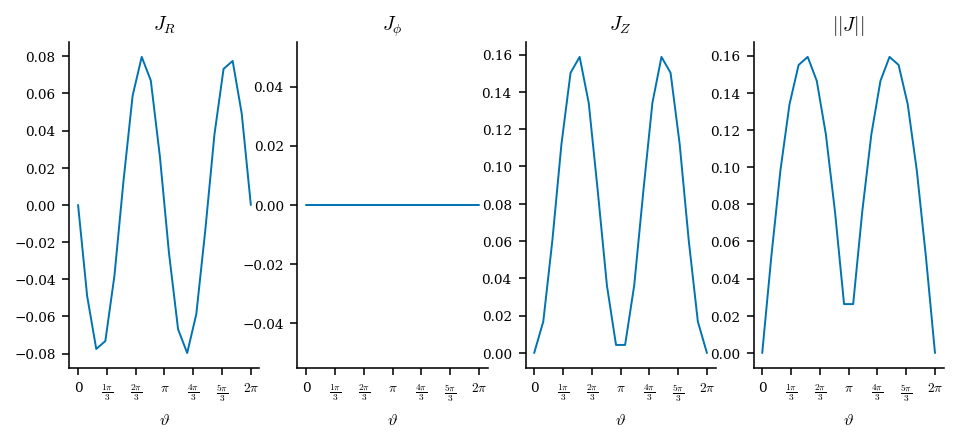

In [138]:
axn = np.where(nodes[0]==0)[0]
fig, ax = plt.subplots(1,4, figsize=(8,3))

ax[0].plot(nodes[1,axn],J[0,axn],lw=1)
ax[0].set_title('$J_R$')
ax[0].set_xlabel('$\\vartheta$')
ax[0].set_xticks([0,1/3*np.pi, 2/3*np.pi, 3/3*np.pi,4/3*np.pi, 5/3*np.pi, 6/3*np.pi])
ax[0].set_xticklabels(['0','$\\frac{1\\pi}{3}$','$\\frac{2\\pi}{3}$','$\\pi$','$\\frac{4\\pi}{3}$','$\\frac{5\\pi}{3}$','$2\\pi$'])

ax[1].plot(nodes[1,axn],J[1,axn],lw=1)
ax[1].set_title('$J_\\phi$')
ax[1].set_xlabel('$\\vartheta$')
ax[1].set_xticks([0,1/3*np.pi, 2/3*np.pi, 3/3*np.pi,4/3*np.pi, 5/3*np.pi, 6/3*np.pi])
ax[1].set_xticklabels(['0','$\\frac{1\\pi}{3}$','$\\frac{2\\pi}{3}$','$\\pi$','$\\frac{4\\pi}{3}$','$\\frac{5\\pi}{3}$','$2\\pi$'])

ax[2].plot(nodes[1,axn],J[2,axn],lw=1)
ax[2].set_title('$J_Z$')
ax[2].set_xlabel('$\\vartheta$')
ax[2].set_xticks([0,1/3*np.pi, 2/3*np.pi, 3/3*np.pi,4/3*np.pi, 5/3*np.pi, 6/3*np.pi])
ax[2].set_xticklabels(['0','$\\frac{1\\pi}{3}$','$\\frac{2\\pi}{3}$','$\\pi$','$\\frac{4\\pi}{3}$','$\\frac{5\\pi}{3}$','$2\\pi$'])

ax[3].plot(nodes[1,axn],np.linalg.norm(J[:,axn],axis=0),lw=1)
ax[3].set_title('$||J||$')
ax[3].set_xlabel('$\\vartheta$')
ax[3].set_xticks([0,1/3*np.pi, 2/3*np.pi, 3/3*np.pi,4/3*np.pi, 5/3*np.pi, 6/3*np.pi])
ax[3].set_xticklabels(['0','$\\frac{1\\pi}{3}$','$\\frac{2\\pi}{3}$','$\\pi$','$\\frac{4\\pi}{3}$','$\\frac{5\\pi}{3}$','$2\\pi$']);


In [ ]:
logerr = np.sign(F_err)*np.log(np.abs(F_err))
plt.quiver(R,Z,logerr[0],logerr[2],headwidth=3,headlength=5,width=2e-3)
plt.plot(bdryR,bdryZ)
plt.scatter(R,Z,s=3)
plt.axis('equal');

In [103]:
from sympy import symbols, Function, Matrix, diff, pi, latex, expand, simplify, zeros, eye, det, sqrt
from sympy.vector import CoordSys3D, curl, gradient, divergence

rho, theta, zeta = symbols(['\\rho','\\theta','\zeta'], real=True)
X = Matrix([rho,theta,zeta])
R = Function('R', real=True)(rho,theta,zeta)
Z = Function('Z', real=True)(rho,theta,zeta)
dR = Function('{\delta}R')(rho,theta,zeta)
dZ = Function('{\delta}Z')(rho,theta,zeta)
xi_R = Function('\\xi_R')(rho,theta,zeta)
xi_P = Function('\\xi_\\phi')(rho,theta,zeta)
xi_Z = Function('\\xi_Z')(rho,theta,zeta)


xi = Matrix([xi_R,xi_P,xi_Z])

e_r = Matrix([R.diff(rho),   0, Z.diff(rho)])
e_t = Matrix([R.diff(theta), 0, Z.diff(theta)])
e_z = Matrix([R.diff(zeta),  -R, Z.diff(zeta)])

de_r = Matrix([dR.diff(rho),   0,  dZ.diff(rho)])
de_t = Matrix([dR.diff(theta), 0,  dZ.diff(theta)])
de_z = Matrix([dR.diff(zeta),  dR, dZ.diff(zeta)])

psi_a = symbols("psi_a")
iota = Function('\iota')(rho)
pres = Function('p')(rho)
psi = psi_a*rho**2
psi = Function('\\Psi')(rho)
covG = eye(3)
conG = eye(3)
covE = Matrix([e_r.T,e_t.T,e_z.T]).T
covE = simplify(covE)

g = e_t.cross(e_z).dot(e_r)
eR = e_t.cross(e_z)/g
eT = e_z.cross(e_r)/g
eZ = e_r.cross(e_t)/g

conE = Matrix([eR.T,eT.T,eZ.T]).T
conE = simplify(conE)

for i in range(3):
    for j in range(3):
        covG[i,j] = covE[:,i].dot(covE[:,j])
        conG[i,j] = conE[:,i].dot(conE[:,j])

BZ = psi.diff(rho)/(2*pi*g)
BT = iota*BZ





# conB = Matrix([0,BT,BZ])
# conB = simplify(conB)

# covB = covG*conB
# covB = simplify(covB)

# conJ = zeros(3,1)

# for i in range(3):
#     for j in range(3):
#         conJ += covB[j].diff(X[i])*conE[:,i].cross(conE[:,j])

# # conJ = simplify(conJ)

# B = BZ*e_z + BT*e_t
# J = covE*conJ

# JxB = J.cross(B)

In [76]:
g = Function('g')(rho,theta,zeta)
g = sqrt(g)
b_r = Function('b_\\rho')(rho,theta,zeta)
b_t = Function('b_\\theta')(rho,theta,zeta)
b_z = Function('b_\\zeta')(rho,theta,zeta)
b = Matrix([b_r,b_t,b_z])
mu0 = symbols('\mu_0')
coords = Matrix([rho,theta,zeta])
covB = 1/(2*pi*g)*b

JR = 1/(mu0*g)*(covB[2].diff(coords[1]) - covB[1].diff(coords[2]))
JT = 1/(mu0*g)*(covB[0].diff(coords[2]) - covB[2].diff(coords[0]))
JZ = 1/(mu0*g)*(covB[1].diff(coords[0]) - covB[0].diff(coords[1]))
conJ = Matrix([JR,JT,JZ])

eR = e_t.cross(e_z)/g
eT = e_z.cross(e_r)/g
eZ = e_r.cross(e_t)/g

BZ = psi.diff(rho)/(2*pi*g)
BT = iota*BZ

conB = Matrix([0,BT,BZ])

F = g*((JT*BZ - JZ*BT)*eR - JR*BZ*eT + JR*BT*eZ)

In [78]:
simplify(F)

Matrix([
[                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             (-(2*(-Derivative(b_\theta(\rho, \theta, \zeta), \zeta) + Derivative(b_\zeta(\rho, \theta, \zeta), \theta))*g(\rho, \theta, \zeta) + b_\theta(\rho, \theta, \zeta)*Derivative(g(\rho, \theta, \zeta), \zeta) - b_\zeta(\rho, \theta, \zeta)*Derivative(g(\rho, \theta, \zeta), \theta))*Derivativ

In [104]:
simplify(eZ)

Matrix([
[                        0],
[-1/R(\rho, \theta, \zeta)],
[                        0]])

In [36]:
print(latex(simplify(conG*g**2)))

\left[\begin{matrix}\left(\frac{\partial}{\partial \theta} R{\left(\rho,\theta,\zeta \right)} \frac{\partial}{\partial \zeta} Z{\left(\rho,\theta,\zeta \right)} - \frac{\partial}{\partial \zeta} R{\left(\rho,\theta,\zeta \right)} \frac{\partial}{\partial \theta} Z{\left(\rho,\theta,\zeta \right)}\right)^{2} + \left(\left(\frac{\partial}{\partial \theta} R{\left(\rho,\theta,\zeta \right)}\right)^{2} + \left(\frac{\partial}{\partial \theta} Z{\left(\rho,\theta,\zeta \right)}\right)^{2}\right) R^{2}{\left(\rho,\theta,\zeta \right)} & - \left(\frac{\partial}{\partial \rho} R{\left(\rho,\theta,\zeta \right)} \frac{\partial}{\partial \theta} R{\left(\rho,\theta,\zeta \right)} + \frac{\partial}{\partial \rho} Z{\left(\rho,\theta,\zeta \right)} \frac{\partial}{\partial \theta} Z{\left(\rho,\theta,\zeta \right)}\right) R^{2}{\left(\rho,\theta,\zeta \right)} - \left(\frac{\partial}{\partial \rho} R{\left(\rho,\theta,\zeta \right)} \frac{\partial}{\partial \zeta} Z{\left(\rho,\theta,\zeta \right)

In [74]:
from sympy import symbols, Matrix, diff, pi

er_R, er_P, er_Z = symbols("R_rho phi_rho Z_rho")
ev_R, ev_P, ev_Z = symbols("R_theta phi_theta Z_theta")
ez_R, ez_P, ez_Z = symbols("R_\zeta R Z_\zeta")
psi_a, rho, iota = symbols("psi_a rho iota")

psi = psi_a*rho**2
e_r = Matrix([er_R,0,er_Z])
e_v = Matrix([ev_R,0,ev_Z])
e_z = Matrix([ez_R,ez_P,ez_Z])

g = e_v.cross(e_z).dot(e_r)

erho = e_v.cross(e_z)/g
etheta = e_z.cross(e_r)
ezeta = e_r.cross(e_v)

Bzeta = diff(psi,rho)/(2*pi*g)
Btheta = iota*Bzeta
B = Btheta*etheta + Bzeta*ezeta


beta = Bzeta*etheta - Btheta*ezeta

In [72]:
erho

Matrix([
[                         -R*Z_theta/(-R*R_rho*Z_theta + R*R_theta*Z_rho)],
[(R_\zeta*Z_theta - R_theta*Z_\zeta)/(-R*R_rho*Z_theta + R*R_theta*Z_rho)],
[                          R*R_theta/(-R*R_rho*Z_theta + R*R_theta*Z_rho)]])

In [73]:
beta

Matrix([
[                                                                                                                      R*Z_rho*psi_a*rho/(pi*(-R*R_rho*Z_theta + R*R_theta*Z_rho))],
[-iota*psi_a*rho*(-R_rho*Z_theta + R_theta*Z_rho)/(pi*(-R*R_rho*Z_theta + R*R_theta*Z_rho)) + psi_a*rho*(-R_\zeta*Z_rho + R_rho*Z_\zeta)/(pi*(-R*R_rho*Z_theta + R*R_theta*Z_rho))],
[                                                                                                                     -R*R_rho*psi_a*rho/(pi*(-R*R_rho*Z_theta + R*R_theta*Z_rho))]])

$$
\begin{equation}
\begin{pmatrix}
\dot{R} \\ 
\dot{\phi} \\ 
\dot{Z}\\
\end{pmatrix} 
= 
\begin{pmatrix}
\frac{\partial R}{\partial t} \\
\frac{\partial \phi}{\partial R}\frac{\partial R}{\partial t} +  \frac{\partial \phi}{\partial Z}\frac{\partial Z}{\partial t}  \\
\frac{\partial Z}{\partial t} \\
\end{pmatrix}
\end{equation}
$$

$$
\begin{equation}
\begin{pmatrix}
\dot{R} \\ 
\dot{\phi} \\ 
\dot{Z}\\
\end{pmatrix} 
= 
\begin{pmatrix}
1 & 0 \\
\frac{\partial \phi}{\partial R} & \frac{\partial \phi}{\partial Z} \\
0 & 1 \\
\end{pmatrix}
\begin{pmatrix}
\frac{\partial R}{\partial t} \\
\frac{\partial Z}{\partial t} \\
\end{pmatrix}
\end{equation}
$$

$$
\vartheta = \pi - \theta + \lambda(\theta,\phi)
$$

In [151]:
r, t, z = symbols(['\\rho','\\theta','\zeta'])
x = Function('x')(r,t,z)
c = Function('c')(r,t,z)
g = Function('g')(x,c)

In [156]:
print(latex(simplify(g.diff(z))))

\frac{\partial}{\partial \zeta} c{\left(\rho,\theta,\zeta \right)} \frac{\partial}{\partial c{\left(\rho,\theta,\zeta \right)}} g{\left(x{\left(\rho,\theta,\zeta \right)},c{\left(\rho,\theta,\zeta \right)} \right)} + \frac{\partial}{\partial x{\left(\rho,\theta,\zeta \right)}} g{\left(x{\left(\rho,\theta,\zeta \right)},c{\left(\rho,\theta,\zeta \right)} \right)} \frac{\partial}{\partial \zeta} x{\left(\rho,\theta,\zeta \right)}


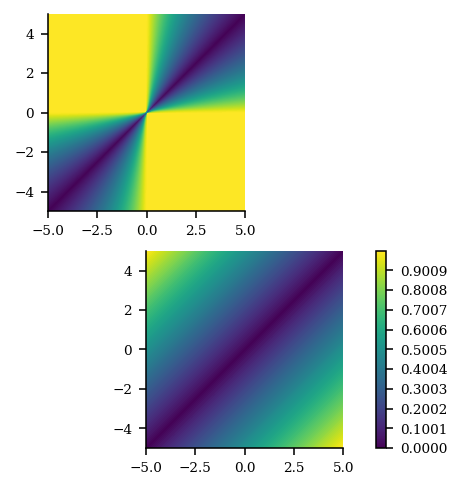

In [134]:
x = np.linspace(-5,5,100)
y = np.linspace(-5,5,100)
xx,yy = np.meshgrid(x,y)
levels = np.linspace(0,1,1000)

z = abs(xx-yy)/(abs(xx)+abs(yy))

fig, ax = plt.subplots(2)
im = ax[0].contourf(x,y,z, levels=levels)
ax[0].set_aspect('equal')
ax[1].contourf(x,y,abs(xx-yy),levels=100)
ax[1].set_aspect('equal')

plt.colorbar(im)